In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sktime.performance_metrics.forecasting import mean_absolute_scaled_error
from prophet import Prophet

In [23]:
data = pd.read_csv('../data/regional_multivariate_data.csv')


enc = pd.read_csv('../data/regional_datasets/multivariate/enc_data_multi.csv').drop(columns = 'Unnamed: 0')
esc = pd.read_csv('../data/regional_datasets/multivariate/esc_data_multi.csv').drop(columns = 'Unnamed: 0')
midatl = pd.read_csv('../data/regional_datasets/multivariate/mid_atlantic_data_multi.csv').drop(columns = 'Unnamed: 0')
mount = pd.read_csv('../data/regional_datasets/multivariate/mountain_data_multi.csv').drop(columns = 'Unnamed: 0')
ne = pd.read_csv('../data/regional_datasets/multivariate/new_england_data_multi.csv').drop(columns = 'Unnamed: 0')
pac = pd.read_csv('../data/regional_datasets/multivariate/pacific_data_multi.csv').drop(columns = 'Unnamed: 0')
satl = pd.read_csv('../data/regional_datasets/multivariate/south_atlantic_data_multi.csv').drop(columns = 'Unnamed: 0')
wnc = pd.read_csv('../data/regional_datasets/multivariate/wnc_data_multi.csv').drop(columns = 'Unnamed: 0')
wsc = pd.read_csv('../data/regional_datasets/multivariate/wsc_data_multi.csv').drop(columns = 'Unnamed: 0')

# datasets = [enc, esc, midatl, mount, ne, pac, satl, wnc, wsc]
# for i in datasets:
#     df = i.drop(columns=['date', 'region'])
#     correlation_matrix = df.corr().abs()
#     columns_to_keep = correlation_matrix[correlation_matrix['new_confirmed'] >= 0.15].index.tolist()
#     columns_to_keep = [col for col in columns_to_keep if col not in ['new_confirmed']] 
#     columns_to_keep.append('date')
#     columns_to_keep.append('region')
#     i = i[columns_to_keep]
#     print(i.shape)

# def log_transform(x):
#     return np.log(x) if x > 0 else 0

def prepare_and_split_data(data, test_size = 0.15):
    data = data.copy() 
    data = data.rename(columns = {'date': 'ds', 'new_confirmed':'y'})
    data = data.sort_values(by = 'ds')

    data2 = data.drop(columns = ['ds', 'region'])
    correlation_matrix = data2.corr().abs()
    columns_to_keep = correlation_matrix[correlation_matrix['y'] >= 0.15].index.tolist()
    columns_to_keep = [col for col in columns_to_keep if col not in ['y']] 
    columns_to_keep.append('ds')
    columns_to_keep.append('region')
    columns_to_keep.append('y')
    data = data[columns_to_keep]

    # This removes the first n observations so that there are no NaNs in the lag columns
    last_nan = data[data.isna().any(axis = 1)].tail(1).index.item()
    data = data[(last_nan + 1):]
    # data['y'] = data['y'].apply(lambda x: log_transform(x))
    testsize = int(len(data) * (1-test_size))
    train, test = data[0:testsize], data[testsize:]
    print(data.shape)
    return train, test

enc_train, enc_test = prepare_and_split_data(enc)
esc_train, esc_test = prepare_and_split_data(esc)
midatl_train, midatl_test = prepare_and_split_data(midatl)
mount_train, mount_test = prepare_and_split_data(mount)
ne_train, ne_test = prepare_and_split_data(ne)
pac_train, pac_test = prepare_and_split_data(pac)
satl_train, satl_test = prepare_and_split_data(satl)
wnc_train, wnc_test = prepare_and_split_data(wnc)
wsc_train, wsc_test = prepare_and_split_data(wsc)
print("Length enc train: ", len(enc_train))
print("Length enc test: ", len(midatl_test))

midatl_test.head()

(856, 39)
(850, 36)
(837, 38)
(846, 38)
(843, 36)
(852, 40)
(838, 37)
(821, 38)
(843, 25)
Length enc train:  727
Length enc test:  126


new_deceased  cumulative_confirmed  cumulative_deceased  \
720          79.0             9797202.0             141918.0   
721          99.0             9802627.0             142017.0   
722         332.0             9809015.0             142349.0   
723         151.0             9815292.0             142500.0   
724         163.0             9820861.0             142663.0   

     new_hospitalized_patients  cumulative_hospitalized_patients  \
720                      435.0                          537379.0   
721                      540.0                          537919.0   
722                      504.0                          538423.0   
723                      512.0                          538935.0   
724                      516.0                          539451.0   

     current_hospitalized_patients  current_intensive_care_patients  \
720                         5374.0                            925.0   
721                         5192.0                            851.0   
722                         4944.0                            818.0   
723                         4706.0                            796.0   
724                         4529.0                            772.0   

     cumulative_persons_vaccinated  cumulative_persons_fully_vaccinated  \
720                     35736149.0                           29736538.0   
721                     35778758.0                           29773251.0   
722                     35803458.0                           29793587.0   
723                     35821992.0                           29810726.0   
724                     35837872.0                           29826512.0   

     new_vaccine_doses_administered  ...  minimum_temperature_celsius  \
720                             0.0  ...                    -6.623457   
721                        171634.0  ...                    -3.395062   
722                         82087.0  ...                    -4.355556   
723                         70053.0  ...                   -10.905556   
724                         64480.0  ...                   -10.488889   

     maximum_temperature_celsius  1_day_shift    7_day_avg  2_day_shift  \
720                    15.271605       4437.0  7340.000000       7660.0   
721                    16.981481       4514.0  7208.857143       4437.0   
722                    21.122222       5425.0  6954.142857       4514.0   
723                    12.709877       6388.0  6396.857143       5425.0   
724                     7.877778       6277.0  5752.857143       6388.0   

     8_day_shift  9_day_shift          ds        region       y  
720       8909.0       9569.0  2022-02-21  Mid-Atlantic  4514.0  
721       5665.0       8909.0  2022-02-22  Mid-Atlantic  5425.0  
722       6343.0       5665.0  2022-02-23  Mid-Atlantic  6388.0  
723       8171.0       6343.0  2022-02-24  Mid-Atlantic  6277.0  
724      10178.0       8171.0  2022-02-25  Mid-Atlantic  5569.0  

[5 rows x 38 columns]

In [24]:
def search_prophet(train, test, changepoints = np.logspace(-3, -1, num = 5), seasonalities = np.array([10, 100, 500]), n_changepoints_vals = np.array([15, 25, 50]), transformation = None, figsize = (15,5), holidays = 'True'):
    models = {}

    for changepoint, seasonality, n_changepoint in itertools.product(changepoints, seasonalities, n_changepoints_vals):
        model = Prophet(changepoint_prior_scale=changepoint)
        for col in train.columns:
            if col not in ['ds', 'y', 'region']:
                model.add_regressor(col)
        if holidays == 'True':
            model.add_country_holidays(country_name= 'US')
        model.fit(train)

        test_forecast = model.predict(test)

        test['ds'] = pd.to_datetime(test['ds'])
        test_forecast['ds'] = pd.to_datetime(test_forecast['ds'])

        min_test_date = test['ds'].min()
        max_test_date = test['ds'].max()
        forecast_filtered = test_forecast[(test_forecast['ds'] >= min_test_date) & (test_forecast['ds'] <= max_test_date)]
        
        y_actual = test['y'].values
        y_pred = forecast_filtered['yhat'].values

        # mae = mean_absolute_error(y_actual, y_pred) 
        # rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
        mase = mean_absolute_scaled_error(y_actual, y_pred, y_train = train['y'])
        
        models[changepoint] = (model, mase, test_forecast, changepoint, seasonality, n_changepoint)

    best_changepoint = min(models, key = lambda k: models[k][1])
    model, best_mase, test_forecast, changepoint, seasonality, n_changepoint = models[best_changepoint] 
    print('changepoint_prior_scale: ', changepoint)
    print('seasonality_prior_scale: ', seasonality)
    print('n_changepoints: ', n_changepoint)

    train_forecast = model.predict(train)

    combined_forecast = pd.concat([train_forecast, test_forecast], ignore_index=True)

    fig1 = model.plot(combined_forecast)
    fig2 = model.plot_components(combined_forecast)

    test['ds'] = pd.to_datetime(test['ds'])
    test_forecast['ds'] = pd.to_datetime(test_forecast['ds'])

    min_test_date = test['ds'].min()
    max_test_date = test['ds'].max()
    forecast_filtered = test_forecast[(test_forecast['ds'] >= min_test_date) & (test_forecast['ds'] <= max_test_date)]
    for i in range(len(forecast_filtered['yhat'])):
        if forecast_filtered['yhat'][i] < 0:
            forecast_filtered['yhat'][i] = 0


    plt.figure(figsize = figsize)
    plt.plot(test['ds'], test['y'], label='New Cases')
    plt.plot(forecast_filtered['ds'], forecast_filtered['yhat'], label='Predicted New Cases')
    # plt.fill_between(forecast_filtered['ds'], forecast_filtered['yhat_lower'], forecast_filtered['yhat_upper'], color='red', alpha=0.2)
    plt.xlabel('Date')
    plt.ylabel('Caseload')
    plt.title('Actual and Predicted Daily New Cases')
    plt.legend()
    plt.show()

    y_actual = test['y'].values
    y_pred = forecast_filtered['yhat'].values
    for i in range(len(y_pred)):
        if y_pred[i] < 0:
            y_pred[i] = 0

    mae = mean_absolute_error(y_actual, y_pred)
    rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
    mse = mean_squared_error(y_actual, y_pred)
    mase = mean_absolute_scaled_error(y_actual, y_pred, y_train = train['y'])

    print(f"MAE: {mae}")
    print(f"RMSE: {rmse}")
    print(f"MSE: {mse}")
    print(f"MASE: {mase}")

    test_avg = test.copy()
    test_avg['7_day_avg'] = test_avg['y'].rolling(window=7).mean()
    forecast_filtered['7_day_avg'] = forecast_filtered['yhat'].rolling(window=7).mean()

    plt.figure(figsize = figsize)
    plt.plot(test_avg['ds'], test_avg['7_day_avg'], label='7-Day Avg New Cases', color='blue', linestyle='--')
    plt.plot(forecast_filtered['ds'], forecast_filtered['7_day_avg'], label='7-Day Avg Predicted New Cases', color='red', linestyle='--')

    plt.xlabel('Date')
    plt.ylabel('Caseload')
    plt.title('Actual and Predicted Daily New Cases')
    plt.legend()
    plt.show()

    y_actual = test_avg['7_day_avg'].values
    y_actual = y_actual[7:]
    y_pred = forecast_filtered['7_day_avg'].values
    y_pred = y_pred[7:]

    mae = mean_absolute_error(y_actual, y_pred)
    rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
    mse = mean_squared_error(y_actual, y_pred)
    mape = mean_absolute_percentage_error(y_actual, y_pred)

    # Calculate MASE
    naive = y_actual[:-1]
    naive_mae = mean_absolute_error(y_actual[1:], naive)
    mase = mae / naive_mae

    print(f"7-Day Avg MAE: {mae}")
    print(f"7-Day Avg RMSE: {rmse}")
    print(f"7-Day Avg MSE: {mse}")
    print(f"7-Day Avg MASE: {mase}")
    print(f"7-Day Avg MAPE: {mape}")

    return model, models, forecast_filtered, fig1, fig2

In [25]:
def check_hyperparams(train, test, changepoints = np.logspace(-3.5, .5, num = 50), seasonalities = np.logspace(-2, 2, num = 50), \
                      n_changepoints_vals = np.logspace(1, 2, num = 50), param = 'changepoint_prior_scale', metric = 'MASE', holidays = 'True'):
    param_vals = []
    mae_values = []
    rmse_values = []
    mase_values = []

    if param == 'changepoint_prior_scale':
        for cps in changepoints:
            m = Prophet(changepoint_prior_scale=cps)
            for col in train.columns:
                if col not in ['ds', 'y', 'region']:
                    m.add_regressor(col)
            if holidays == 'True':
                m.add_country_holidays(country_name= 'US')
            m.fit(train)
            
            forecast = m.predict(test)

            forecasted = forecast['yhat'][-len(test):]
            mae = mean_absolute_error(test['y'], forecasted)
            rmse = np.sqrt(mean_squared_error(test['y'], forecasted))
            mase = mean_absolute_scaled_error(test['y'], forecasted, y_train = train['y'])
            
            param_vals.append(cps)
            mae_values.append(mae)
            rmse_values.append(rmse)
            mase_values.append(mase)
    elif param == 'seasonality_prior_scale':
        for sps in seasonalities:
            m = Prophet(seasonality_prior_scale=sps)
            for col in train.columns:
                if col not in ['ds', 'y', 'region']:
                    m.add_regressor(col)
            if holidays == 'True':
                m.add_country_holidays(country_name= 'US')
            m.fit(train)
            
            forecast = m.predict(test)

            forecasted = forecast['yhat'][-len(test):]
            mae = mean_absolute_error(test['y'], forecasted)
            rmse = np.sqrt(mean_squared_error(test['y'], forecasted))
            mase = mean_absolute_scaled_error(test['y'], forecasted, y_train = train['y'])
            
            param_vals.append(sps)
            mae_values.append(mae)
            rmse_values.append(rmse)
            mase_values.append(mase)
    elif param == 'n_changepoints':
        for ncps in n_changepoints_vals:
            m = Prophet(n_changepoints = int(ncps))
            for col in train.columns:
                if col not in ['ds', 'y', 'region']:
                    m.add_regressor(col)
            if holidays == 'True':
                m.add_country_holidays(country_name= 'US')
            m.fit(train)
            
            forecast = m.predict(test)

            forecasted = forecast['yhat'][-len(test):]
            mae = mean_absolute_error(test['y'], forecasted)
            rmse = np.sqrt(mean_squared_error(test['y'], forecasted))
            mase = mean_absolute_scaled_error(test['y'], forecasted, y_train = train['y'])
            
            param_vals.append(ncps)
            mae_values.append(mae)
            rmse_values.append(rmse)
            mase_values.append(mase)

    plt.figure(figsize=(10, 6))
    if metric == 'MAE':
        plt.plot(param_vals, mae_values, marker='o')
        plt.ylabel('MAE')
        sorted_indexes = np.argsort(mae_values)
        print("Lowest 5 MAEs and params:")
        for i in range(5):
            index = sorted_indexes[i]
            print(f"param: {param_vals[index]}, MAE: {mae_values[index]}")
    elif metric == 'RMSE':
        plt.plot(param_vals, rmse_values, marker='o')
        plt.ylabel('RMSE')
        sorted_indexes = np.argsort(rmse_values)
        print("Lowest 5 RMSEs and params:")
        for i in range(5):
            index = sorted_indexes[i]
            print(f"param: {param_vals[index]}, RMSE: {rmse_values[index]}")
    elif metric == 'MASE':
        plt.plot(param_vals, mase_values, marker='o')
        plt.ylabel('MASE')
        sorted_indexes = np.argsort(mase_values)
        print("Lowest 5 MASEs and params:")
        for i in range(5):
            index = sorted_indexes[i]
            print(f"param: {param_vals[index]}, MASE: {mase_values[index]}")
    plt.title('param vs metric')
    plt.xlabel('param')
    plt.xscale('log')
    plt.show()

In [6]:
def old_search_prophet(train, test, changepoints = np.logspace(-3.5, .5, num = 30), transformation = None, figsize = (10,6)):
    models = {}

    for changepoint in changepoints:
        model = Prophet(changepoint_prior_scale=changepoint)
        for col in train.columns:
            if col not in ['ds', 'y', 'region']:
                model.add_regressor(col)
        model.fit(train)

        test_forecast = model.predict(test)

        test['ds'] = pd.to_datetime(test['ds'])
        test_forecast['ds'] = pd.to_datetime(test_forecast['ds'])

        min_test_date = test['ds'].min()
        max_test_date = test['ds'].max()
        forecast_filtered = test_forecast[(test_forecast['ds'] >= min_test_date) & (test_forecast['ds'] <= max_test_date)]
        
        y_actual = test['y'].values
        y_pred = forecast_filtered['yhat'].values

        # mae = mean_absolute_error(y_actual, y_pred) 
        rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
        
        models[changepoint] = (model, rmse, test_forecast)

    best_changepoint = min(models, key = lambda k: models[k][1])
    model, rmse, test_forecast = models[best_changepoint] 

    train_forecast = model.predict(train)

    combined_forecast = pd.concat([train_forecast, test_forecast], ignore_index=True)

    fig1 = model.plot(combined_forecast)
    fig2 = model.plot_components(combined_forecast)

    test['ds'] = pd.to_datetime(test['ds'])
    test_forecast['ds'] = pd.to_datetime(test_forecast['ds'])

    min_test_date = test['ds'].min()
    max_test_date = test['ds'].max()
    forecast_filtered = test_forecast[(test_forecast['ds'] >= min_test_date) & (test_forecast['ds'] <= max_test_date)]


    plt.figure(figsize=(10, 6))
    plt.plot(test['ds'], test['y'], label='New Cases', color='blue')
    plt.plot(forecast_filtered['ds'], forecast_filtered['yhat'], label='Predicted New Cases', color='red')
    # plt.fill_between(forecast_filtered['ds'], forecast_filtered['yhat_lower'], forecast_filtered['yhat_upper'], color='red', alpha=0.2)
    plt.xlabel('Date')
    plt.ylabel('Caseload')
    plt.title('Actual and Predicted Daily New Cases')
    plt.legend()
    plt.show()

    y_actual = test['y'].values
    y_pred = forecast_filtered['yhat'].values

    mae = mean_absolute_error(y_actual, y_pred)
    # rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
    mse = mean_squared_error(y_actual, y_pred)

    # Calculate MASE
    naive = y_actual[:-1]
    naive_mae = mean_absolute_error(y_actual[1:], naive)
    mase = mae / naive_mae

    print(f"MAE: {mae}")
    print(f"RMSE: {rmse}")
    print(f"MSE: {mse}")
    print(f"MASE: {mase}")

    test_avg = test.copy()
    test_avg['7_day_avg'] = test_avg['y'].rolling(window=7).mean()
    forecast_filtered['7_day_avg'] = forecast_filtered['yhat'].rolling(window=7).mean()

    plt.figure(figsize = figsize)
    plt.plot(test_avg['ds'], test_avg['7_day_avg'], label='7-Day Avg New Cases', color='blue', linestyle='--')
    plt.plot(forecast_filtered['ds'], forecast_filtered['7_day_avg'], label='7-Day Avg Predicted New Cases', color='red', linestyle='--')

# Uncomment the following line if you want to include the prediction intervals
# plt.fill_between(forecast_filtered['ds'], forecast_filtered['yhat_lower'], forecast_filtered['yhat_upper'], color='red', alpha=0.2)

    plt.xlabel('Date')
    plt.ylabel('Caseload')
    plt.title('Actual and Predicted Daily New Cases')
    plt.legend()
    plt.show()

    y_actual = test_avg['7_day_avg'].values
    y_actual = y_actual[7:]
    y_pred = forecast_filtered['7_day_avg'].values
    y_pred = y_pred[7:]

    mae = mean_absolute_error(y_actual, y_pred)
    rmse = np.sqrt(mean_squared_error(y_actual, y_pred))
    mse = mean_squared_error(y_actual, y_pred)
    mape = mean_absolute_percentage_error(y_actual, y_pred)

    # Calculate MASE
    naive = y_actual[:-1]
    naive_mae = mean_absolute_error(y_actual[1:], naive)
    mase = mae / naive_mae

    print(f"7-Day Avg MAE: {mae}")
    print(f"7-Day Avg RMSE: {rmse}")
    print(f"7-Day Avg MSE: {mse}")
    print(f"7-Day Avg MASE: {mase}")
    print(f"7-Day Avg MAPE: {mape}")

    return model, models, forecast_filtered, fig1, fig2

# ENC

12:07:41 - cmdstanpy - INFO - Chain [1] start processing
12:07:41 - cmdstanpy - INFO - Chain [1] done processing
12:07:41 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:07:41 - cmdstanpy - INFO - Chain [1] start processing
12:07:45 - cmdstanpy - INFO - Chain [1] done processing
12:07:46 - cmdstanpy - INFO - Chain [1] start processing
12:07:46 - cmdstanpy - INFO - Chain [1] done processing
12:07:46 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:07:46 - cmdstanpy - INFO - Chain [1] start processing
12:07:52 - cmdstanpy - INFO - Chain [1] done processing
12:07:52 - cmdstanpy - INFO - Chain [1] start processing
12:07:53 - cmdstanpy - INFO - Chain [1] done processing
12:07:53 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abn

Lowest 5 MASEs and params:
param: 0.009319395762340775, MASE: 0.556183562054495
param: 0.007722449945836254, MASE: 0.5567099026133749
param: 0.005302611335911982, MASE: 0.5832719183947329
param: 0.00639915233634926, MASE: 0.603401913532626
param: 0.011246578221198195, MASE: 0.6217837280620817


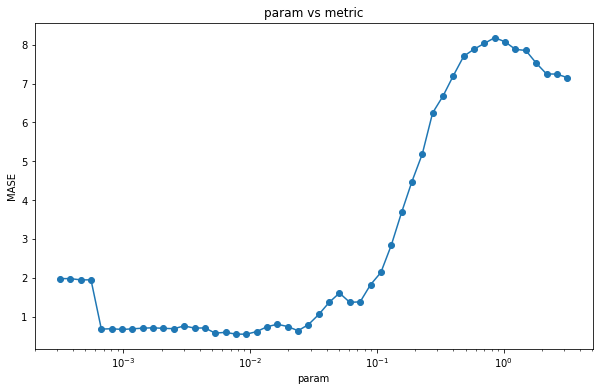

In [53]:
check_hyperparams(enc_train, enc_test)

12:08:43 - cmdstanpy - INFO - Chain [1] start processing
12:08:43 - cmdstanpy - INFO - Chain [1] done processing
12:08:44 - cmdstanpy - INFO - Chain [1] start processing
12:08:44 - cmdstanpy - INFO - Chain [1] done processing
12:08:44 - cmdstanpy - INFO - Chain [1] start processing
12:08:45 - cmdstanpy - INFO - Chain [1] done processing
12:08:45 - cmdstanpy - INFO - Chain [1] start processing
12:08:45 - cmdstanpy - INFO - Chain [1] done processing
12:08:46 - cmdstanpy - INFO - Chain [1] start processing
12:08:46 - cmdstanpy - INFO - Chain [1] done processing
12:08:46 - cmdstanpy - INFO - Chain [1] start processing
12:08:47 - cmdstanpy - INFO - Chain [1] done processing
12:08:47 - cmdstanpy - INFO - Chain [1] start processing
12:08:47 - cmdstanpy - INFO - Chain [1] done processing
12:08:48 - cmdstanpy - INFO - Chain [1] start processing
12:08:48 - cmdstanpy - INFO - Chain [1] done processing
12:08:48 - cmdstanpy - INFO - Chain [1] start processing
12:08:49 - cmdstanpy - INFO - Chain [1]

Lowest 5 MASEs and params:
param: 3237.45754281764, MASE: 1.1209252758676707
param: 0.3906939937054617, MASE: 1.1922455835731878
param: 0.040949150623804255, MASE: 1.1950672831866727
param: 3.727593720314938, MASE: 1.2074044895223757
param: 449.8432668969444, MASE: 1.222315403510378


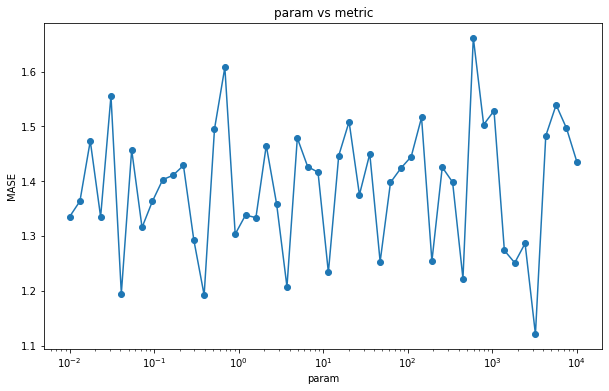

In [54]:
check_hyperparams(enc_train, enc_test, param='seasonality_prior_scale')

12:09:18 - cmdstanpy - INFO - Chain [1] start processing
12:09:18 - cmdstanpy - INFO - Chain [1] done processing
12:09:19 - cmdstanpy - INFO - Chain [1] start processing
12:09:19 - cmdstanpy - INFO - Chain [1] done processing
12:09:19 - cmdstanpy - INFO - Chain [1] start processing
12:09:20 - cmdstanpy - INFO - Chain [1] done processing
12:09:20 - cmdstanpy - INFO - Chain [1] start processing
12:09:21 - cmdstanpy - INFO - Chain [1] done processing
12:09:21 - cmdstanpy - INFO - Chain [1] start processing
12:09:21 - cmdstanpy - INFO - Chain [1] done processing
12:09:22 - cmdstanpy - INFO - Chain [1] start processing
12:09:22 - cmdstanpy - INFO - Chain [1] done processing
12:09:22 - cmdstanpy - INFO - Chain [1] start processing
12:09:23 - cmdstanpy - INFO - Chain [1] done processing
12:09:23 - cmdstanpy - INFO - Chain [1] start processing
12:09:23 - cmdstanpy - INFO - Chain [1] done processing
12:09:24 - cmdstanpy - INFO - Chain [1] start processing
12:09:24 - cmdstanpy - INFO - Chain [1]

Lowest 5 MASEs and params:
param: 323.74575428176433, MASE: 0.6814287871091332
param: 152.64179671752333, MASE: 0.7072542460166685
param: 1000.0, MASE: 0.7369099168546599
param: 828.6427728546843, MASE: 0.7369099168546599
param: 754.3120063354615, MASE: 0.7369099168546599


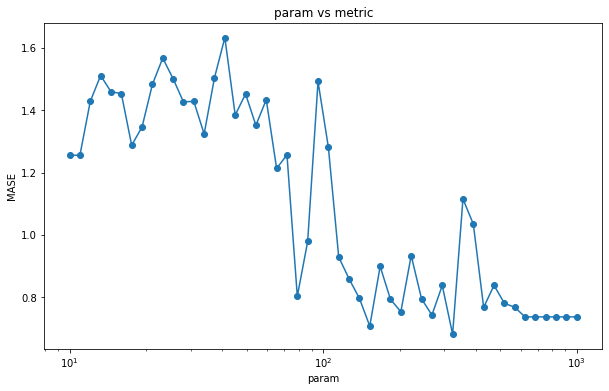

In [55]:
check_hyperparams(enc_train, enc_test, param = 'n_changepoints')

12:13:33 - cmdstanpy - INFO - Chain [1] start processing
12:13:33 - cmdstanpy - INFO - Chain [1] done processing
12:13:34 - cmdstanpy - INFO - Chain [1] start processing
12:13:34 - cmdstanpy - INFO - Chain [1] done processing
12:13:34 - cmdstanpy - INFO - Chain [1] start processing
12:13:35 - cmdstanpy - INFO - Chain [1] done processing
12:13:35 - cmdstanpy - INFO - Chain [1] start processing
12:13:35 - cmdstanpy - INFO - Chain [1] done processing
12:13:36 - cmdstanpy - INFO - Chain [1] start processing
12:13:36 - cmdstanpy - INFO - Chain [1] done processing
12:13:36 - cmdstanpy - INFO - Chain [1] start processing
12:13:37 - cmdstanpy - INFO - Chain [1] done processing
12:13:37 - cmdstanpy - INFO - Chain [1] start processing
12:13:37 - cmdstanpy - INFO - Chain [1] done processing
12:13:38 - cmdstanpy - INFO - Chain [1] start processing
12:13:38 - cmdstanpy - INFO - Chain [1] done processing
12:13:38 - cmdstanpy - INFO - Chain [1] start processing
12:13:39 - cmdstanpy - INFO - Chain [1]

changepoint_prior_scale:  0.0077
seasonality_prior_scale:  450
n_changepoints:  750


/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects inste

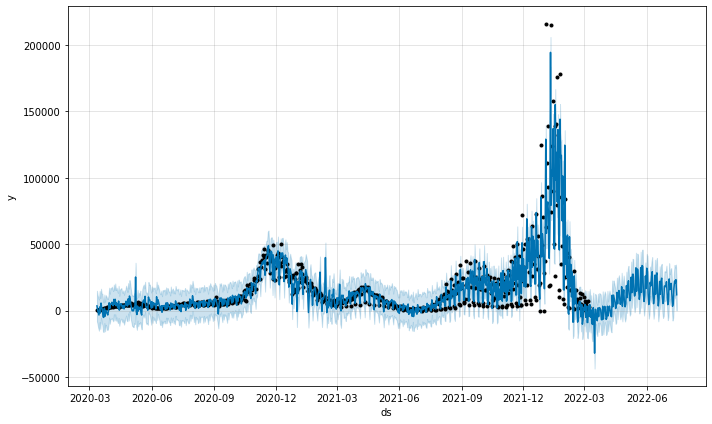

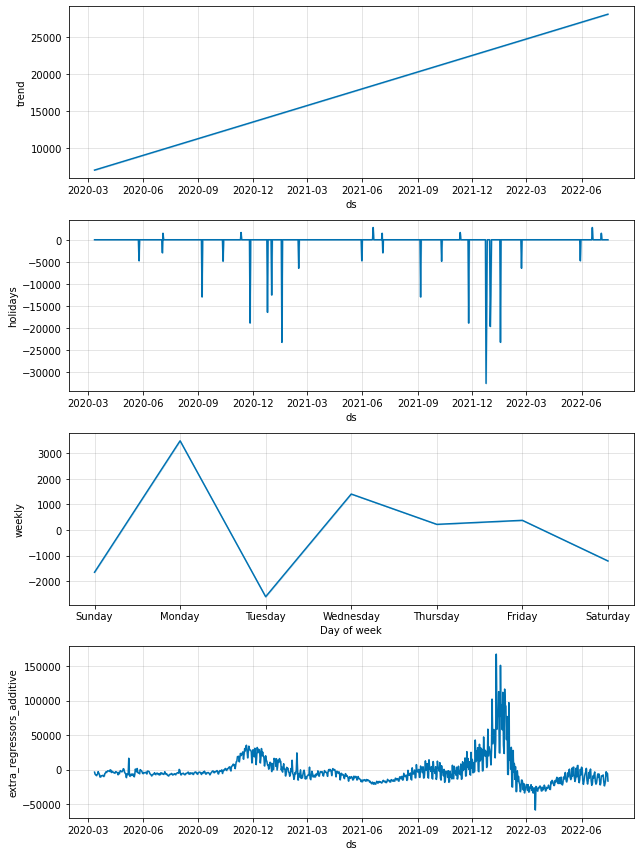

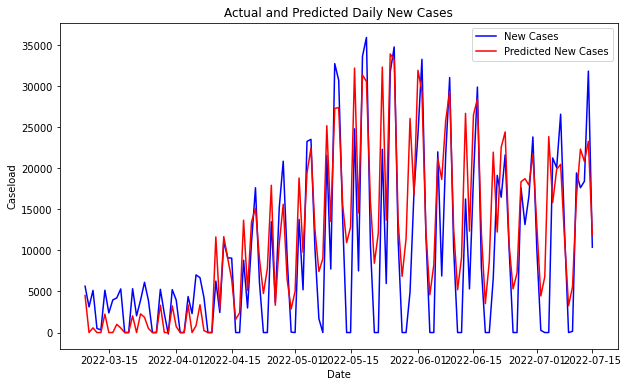

MAE: 4312.320202642934
RMSE: 5797.306326164194
MSE: 33608760.639383376
MASE: 0.49275305345615084


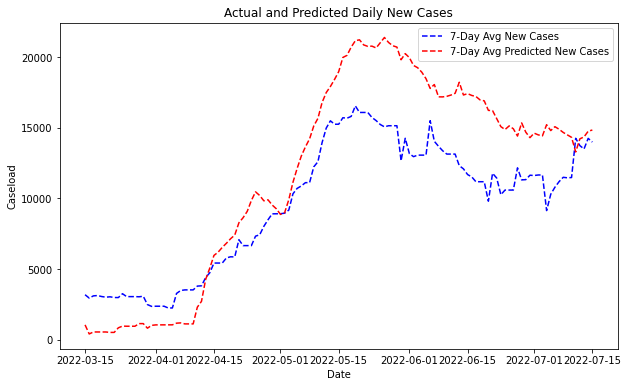

7-Day Avg MAE: 3120.022783915219
7-Day Avg RMSE: 3606.0082341375733
7-Day Avg MSE: 13003295.38466798
7-Day Avg MASE: 7.739429902640445
7-Day Avg MAPE: 0.377430831859405


In [57]:
model, models, forecast_enc, fig1, fig2 = search_prophet(enc_train, enc_test, changepoints=[.0093, .0077, .0053, .0064, .011], seasonalities=[3230, .39, .041, 3.7, 450], n_changepoints_vals=[320, 150, 1000, 830, 750])

12:14:59 - cmdstanpy - INFO - Chain [1] start processing
12:14:59 - cmdstanpy - INFO - Chain [1] done processing
12:14:59 - cmdstanpy - INFO - Chain [1] start processing
12:15:00 - cmdstanpy - INFO - Chain [1] done processing
12:15:00 - cmdstanpy - INFO - Chain [1] start processing
12:15:00 - cmdstanpy - INFO - Chain [1] done processing
12:15:01 - cmdstanpy - INFO - Chain [1] start processing
12:15:01 - cmdstanpy - INFO - Chain [1] done processing
12:15:01 - cmdstanpy - INFO - Chain [1] start processing
12:15:01 - cmdstanpy - INFO - Chain [1] done processing
12:15:02 - cmdstanpy - INFO - Chain [1] start processing
12:15:02 - cmdstanpy - INFO - Chain [1] done processing
12:15:02 - cmdstanpy - INFO - Chain [1] start processing
12:15:02 - cmdstanpy - INFO - Chain [1] done processing
12:15:03 - cmdstanpy - INFO - Chain [1] start processing
12:15:03 - cmdstanpy - INFO - Chain [1] done processing
12:15:04 - cmdstanpy - INFO - Chain [1] start processing
12:15:04 - cmdstanpy - INFO - Chain [1]

changepoint_prior_scale:  0.01
seasonality_prior_scale:  500
n_changepoints:  50


/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects inste

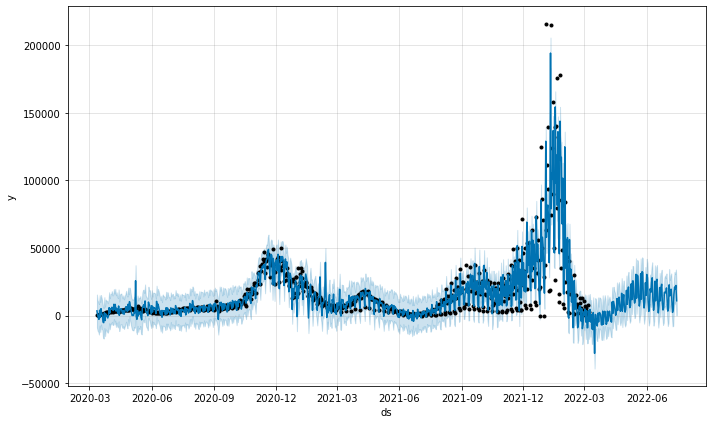

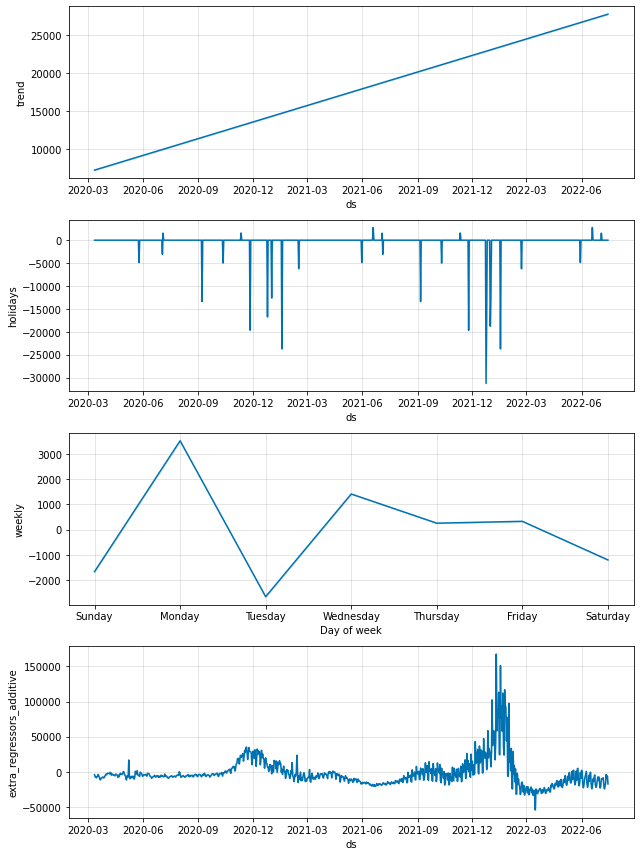

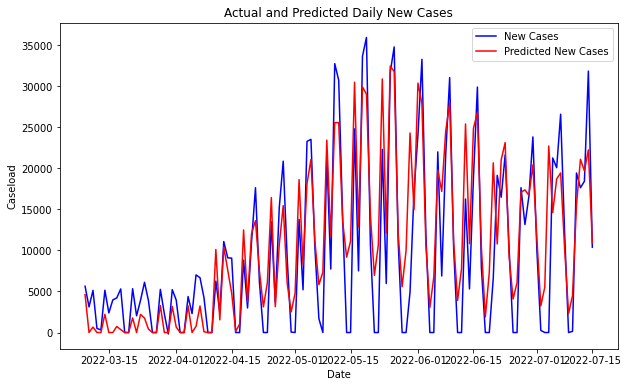

MAE: 3906.3344723823093
RMSE: 5260.724580916299
MSE: 27675223.11625697
MASE: 0.4463625493087684


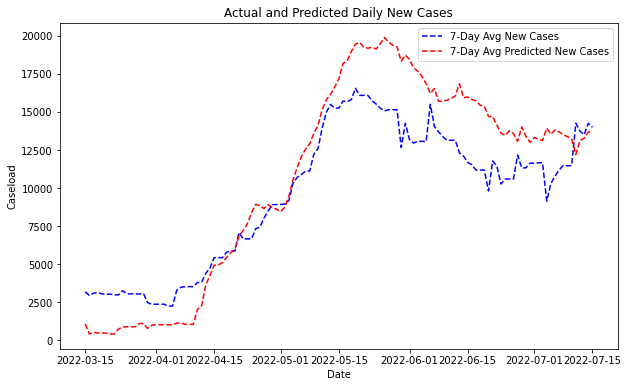

7-Day Avg MAE: 2217.1436662206484
7-Day Avg RMSE: 2611.1225585060997
7-Day Avg MSE: 6817961.015539439
7-Day Avg MASE: 5.499776500755268
7-Day Avg MAPE: 0.3029259408630905


In [58]:
model, models, forecast_enc, fig1, fig2 = search_prophet(enc_train, enc_test)

# ESC

12:16:04 - cmdstanpy - INFO - Chain [1] start processing
12:16:04 - cmdstanpy - INFO - Chain [1] done processing
12:16:04 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:16:04 - cmdstanpy - INFO - Chain [1] start processing
12:16:10 - cmdstanpy - INFO - Chain [1] done processing
12:16:11 - cmdstanpy - INFO - Chain [1] start processing
12:16:11 - cmdstanpy - INFO - Chain [1] done processing
12:16:11 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:16:11 - cmdstanpy - INFO - Chain [1] start processing
12:16:15 - cmdstanpy - INFO - Chain [1] done processing
12:16:15 - cmdstanpy - INFO - Chain [1] start processing
12:16:15 - cmdstanpy - INFO - Chain [1] done processing
12:16:15 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abn

Lowest 5 MASEs and params:
param: 0.18858632787726495, MASE: 0.6090765925911134
param: 0.22758459260747863, MASE: 0.6297650214273641
param: 0.15627069765469948, MASE: 0.6882955173520477
param: 0.0006707035611184306, MASE: 0.780181656650413
param: 0.0008094001216083124, MASE: 0.7989547637812736


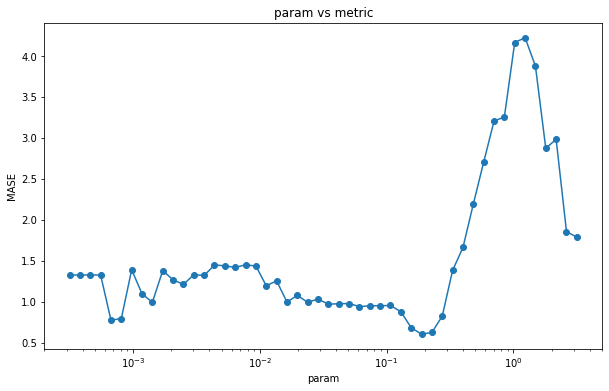

In [59]:
check_hyperparams(esc_train, esc_test)

12:18:04 - cmdstanpy - INFO - Chain [1] start processing
12:18:05 - cmdstanpy - INFO - Chain [1] done processing
12:18:05 - cmdstanpy - INFO - Chain [1] start processing
12:18:05 - cmdstanpy - INFO - Chain [1] done processing
12:18:06 - cmdstanpy - INFO - Chain [1] start processing
12:18:06 - cmdstanpy - INFO - Chain [1] done processing
12:18:06 - cmdstanpy - INFO - Chain [1] start processing
12:18:07 - cmdstanpy - INFO - Chain [1] done processing
12:18:07 - cmdstanpy - INFO - Chain [1] start processing
12:18:07 - cmdstanpy - INFO - Chain [1] done processing
12:18:08 - cmdstanpy - INFO - Chain [1] start processing
12:18:08 - cmdstanpy - INFO - Chain [1] done processing
12:18:09 - cmdstanpy - INFO - Chain [1] start processing
12:18:09 - cmdstanpy - INFO - Chain [1] done processing
12:18:10 - cmdstanpy - INFO - Chain [1] start processing
12:18:10 - cmdstanpy - INFO - Chain [1] done processing
12:18:10 - cmdstanpy - INFO - Chain [1] start processing
12:18:10 - cmdstanpy - INFO - Chain [1]

Lowest 5 MASEs and params:
param: 6.551285568595509, MASE: 0.9252764187891575
param: 0.517947467923121, MASE: 0.9255253393563693
param: 4291.934260128778, MASE: 0.9276066706750915
param: 1.5998587196060574, MASE: 0.9307152323879355
param: 0.16768329368110083, MASE: 0.93150903594073


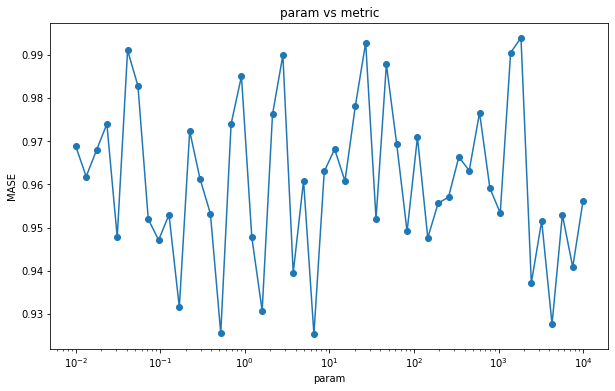

In [60]:
check_hyperparams(esc_train, esc_test, param = 'seasonality_prior_scale')

12:27:54 - cmdstanpy - INFO - Chain [1] start processing
12:27:55 - cmdstanpy - INFO - Chain [1] done processing
12:27:55 - cmdstanpy - INFO - Chain [1] start processing
12:27:55 - cmdstanpy - INFO - Chain [1] done processing
12:27:56 - cmdstanpy - INFO - Chain [1] start processing
12:27:56 - cmdstanpy - INFO - Chain [1] done processing
12:27:57 - cmdstanpy - INFO - Chain [1] start processing
12:27:57 - cmdstanpy - INFO - Chain [1] done processing
12:27:57 - cmdstanpy - INFO - Chain [1] start processing
12:27:58 - cmdstanpy - INFO - Chain [1] done processing
12:27:58 - cmdstanpy - INFO - Chain [1] start processing
12:27:58 - cmdstanpy - INFO - Chain [1] done processing
12:27:59 - cmdstanpy - INFO - Chain [1] start processing
12:27:59 - cmdstanpy - INFO - Chain [1] done processing
12:27:59 - cmdstanpy - INFO - Chain [1] start processing
12:27:59 - cmdstanpy - INFO - Chain [1] done processing
12:28:00 - cmdstanpy - INFO - Chain [1] start processing
12:28:00 - cmdstanpy - INFO - Chain [1]

Lowest 5 MASEs and params:
param: 20.523191520530943, MASE: 0.9178752171094923
param: 10.0, MASE: 0.921386794855831
param: 10.831631524280024, MASE: 0.921386794855831
param: 49.417133613238356, MASE: 0.9276450448702173
param: 336.1480623809069, MASE: 0.9294495189952866


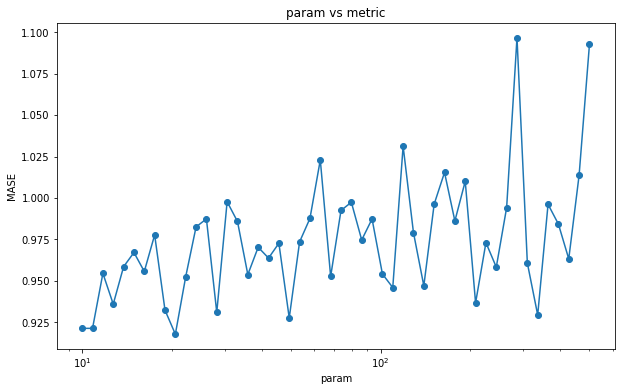

In [69]:
check_hyperparams(esc_train, esc_test, param = 'n_changepoints')

12:31:30 - cmdstanpy - INFO - Chain [1] start processing
12:31:31 - cmdstanpy - INFO - Chain [1] done processing
12:31:31 - cmdstanpy - INFO - Chain [1] start processing
12:31:31 - cmdstanpy - INFO - Chain [1] done processing
12:31:32 - cmdstanpy - INFO - Chain [1] start processing
12:31:32 - cmdstanpy - INFO - Chain [1] done processing
12:31:32 - cmdstanpy - INFO - Chain [1] start processing
12:31:32 - cmdstanpy - INFO - Chain [1] done processing
12:31:33 - cmdstanpy - INFO - Chain [1] start processing
12:31:33 - cmdstanpy - INFO - Chain [1] done processing
12:31:33 - cmdstanpy - INFO - Chain [1] start processing
12:31:34 - cmdstanpy - INFO - Chain [1] done processing
12:31:34 - cmdstanpy - INFO - Chain [1] start processing
12:31:34 - cmdstanpy - INFO - Chain [1] done processing
12:31:35 - cmdstanpy - INFO - Chain [1] start processing
12:31:35 - cmdstanpy - INFO - Chain [1] done processing
12:31:35 - cmdstanpy - INFO - Chain [1] start processing
12:31:35 - cmdstanpy - INFO - Chain [1]

changepoint_prior_scale:  0.23
seasonality_prior_scale:  0.17
n_changepoints:  336


/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects inste

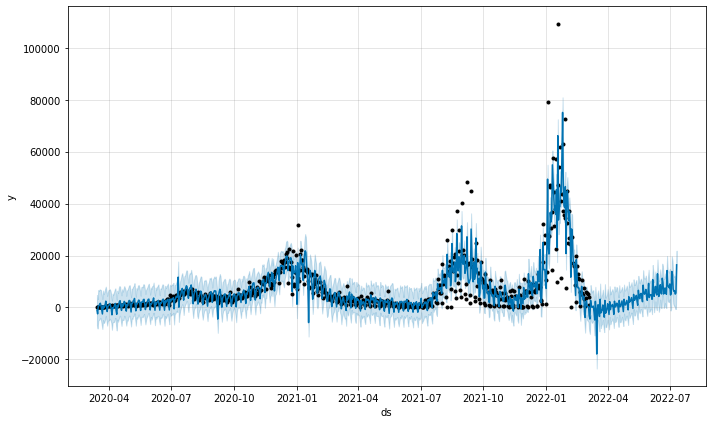

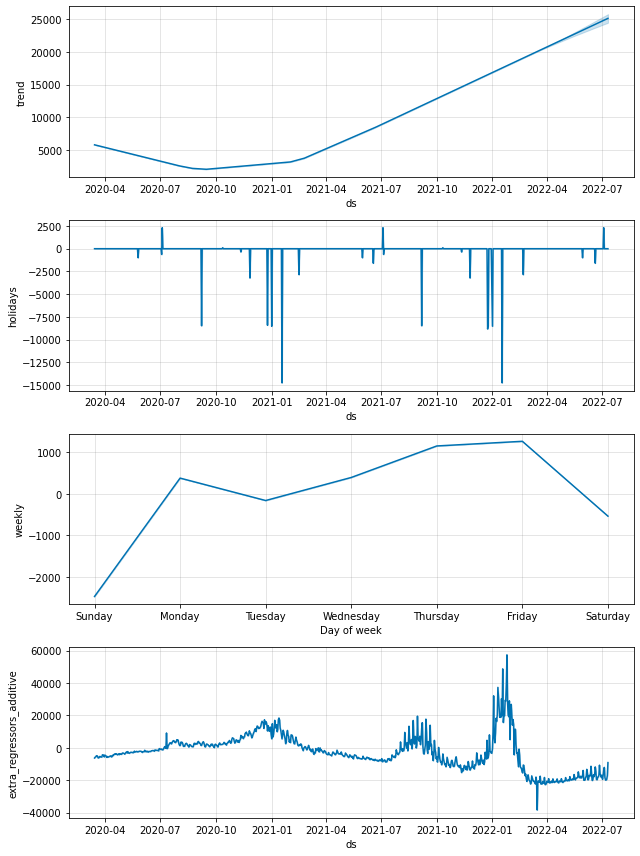

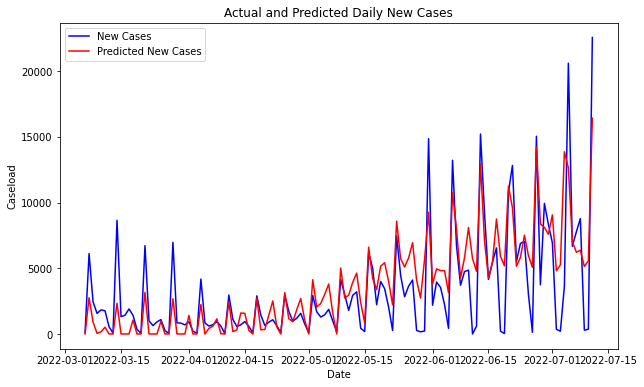

MAE: 1700.8354104913412
RMSE: 2503.3726331183852
MSE: 6266874.540246078
MASE: 0.4646682764239583


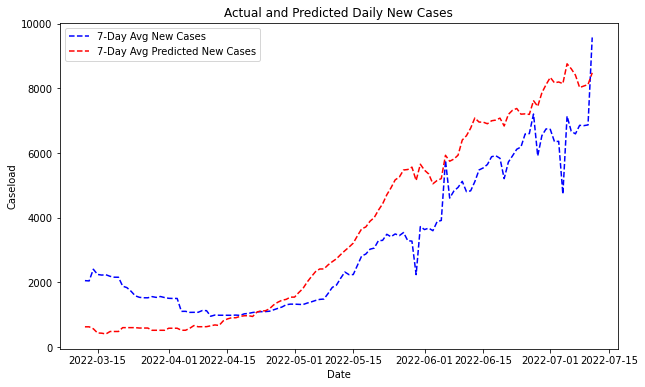

7-Day Avg MAE: 1041.0792442548652
7-Day Avg RMSE: 1222.8468283356212
7-Day Avg MSE: 1495354.3655704884
7-Day Avg MASE: 4.756165103085294
7-Day Avg MAPE: 0.3771631507932365


In [72]:
model, models, forecast_esc, fig1, fig2 = search_prophet(esc_train, esc_test, changepoints=[0.19, 0.23, 0.16, 0.00067, 0.00081], seasonalities=[6.6, 0.52, 4300, 1.6, 0.17], n_changepoints_vals=[21, 10, 11, 49, 336])

12:19:27 - cmdstanpy - INFO - Chain [1] start processing
12:19:27 - cmdstanpy - INFO - Chain [1] done processing
12:19:28 - cmdstanpy - INFO - Chain [1] start processing
12:19:28 - cmdstanpy - INFO - Chain [1] done processing
12:19:28 - cmdstanpy - INFO - Chain [1] start processing
12:19:28 - cmdstanpy - INFO - Chain [1] done processing
12:19:29 - cmdstanpy - INFO - Chain [1] start processing
12:19:29 - cmdstanpy - INFO - Chain [1] done processing
12:19:30 - cmdstanpy - INFO - Chain [1] start processing
12:19:30 - cmdstanpy - INFO - Chain [1] done processing
12:19:30 - cmdstanpy - INFO - Chain [1] start processing
12:19:30 - cmdstanpy - INFO - Chain [1] done processing
12:19:31 - cmdstanpy - INFO - Chain [1] start processing
12:19:31 - cmdstanpy - INFO - Chain [1] done processing
12:19:31 - cmdstanpy - INFO - Chain [1] start processing
12:19:31 - cmdstanpy - INFO - Chain [1] done processing
12:19:32 - cmdstanpy - INFO - Chain [1] start processing
12:19:32 - cmdstanpy - INFO - Chain [1]

changepoint_prior_scale:  0.1
seasonality_prior_scale:  500
n_changepoints:  50


/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects inste

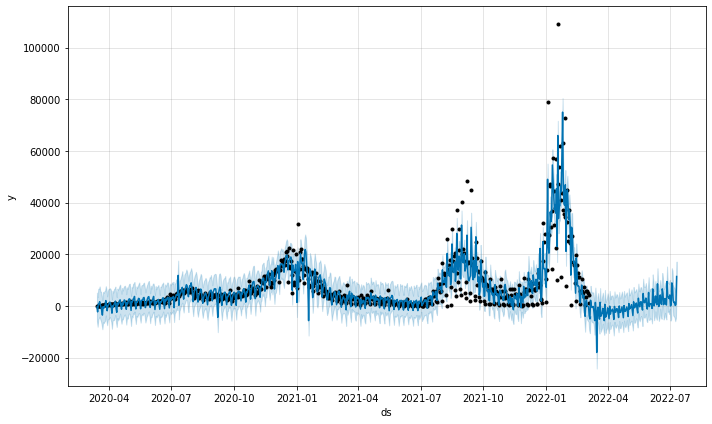

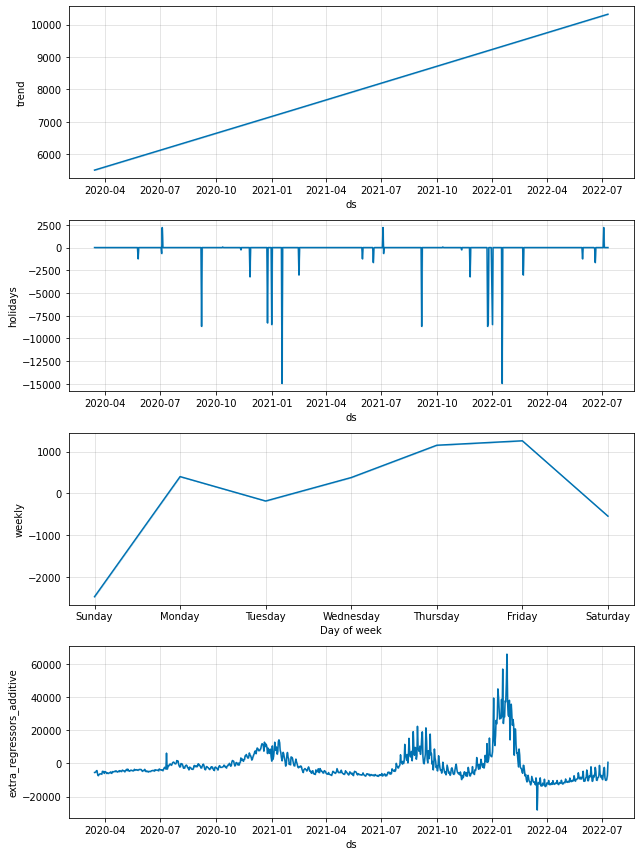

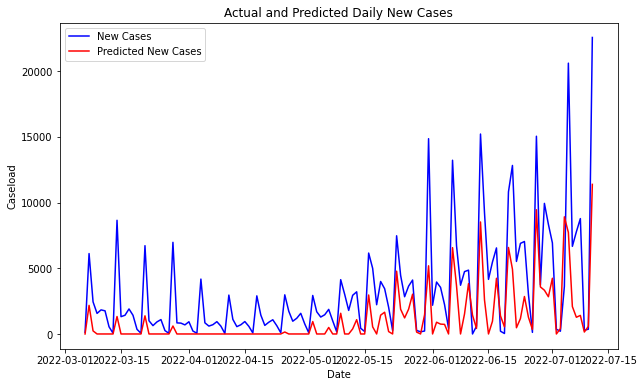

MAE: 2258.536838506385
RMSE: 3288.225088411049
MSE: 10812424.232055852
MASE: 0.6170323204204716


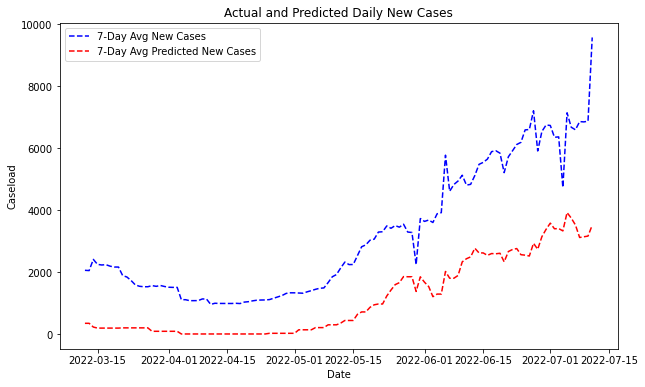

7-Day Avg MAE: 2033.43902757607
7-Day Avg RMSE: 2245.8342451944072
7-Day Avg MSE: 5043771.456887933
7-Day Avg MASE: 9.289755602736196
7-Day Avg MAPE: 0.75845406633678


In [62]:
model, models, forecast_esc, fig1, fig2 = search_prophet(esc_train, esc_test)

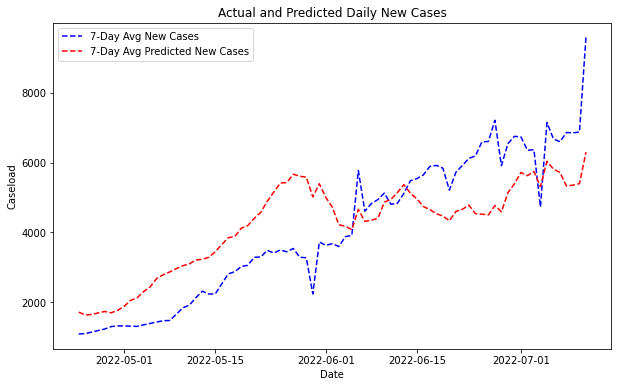

In [181]:
test = esc_test.copy()
test['7_day_avg'] = test['y'].rolling(window=7).mean()
forecast_esc['7_day_avg'] = forecast_esc['yhat'].rolling(window=7).mean()

plt.figure(figsize = (10,6))
# Plot the actual new cases and their rolling average
# plt.plot(test['ds'], test['y'], label='New Cases', color='blue')
plt.plot(test['ds'], test['7_day_avg'], label='7-Day Avg New Cases', color='blue', linestyle='--')

# Plot the predicted new cases and their rolling average
# plt.plot(forecast_mount['ds'], forecast_mount['yhat'], label='Predicted New Cases', color='red')
plt.plot(forecast_esc['ds'], forecast_esc['7_day_avg'], label='7-Day Avg Predicted New Cases', color='red', linestyle='--')

# Uncomment the following line if you want to include the prediction intervals
# plt.fill_between(forecast_filtered['ds'], forecast_filtered['yhat_lower'], forecast_filtered['yhat_upper'], color='red', alpha=0.2)

plt.xlabel('Date')
plt.ylabel('Caseload')
plt.title('Actual and Predicted Daily New Cases')
plt.legend()
plt.show()

# MidATL

12:22:47 - cmdstanpy - INFO - Chain [1] start processing
12:22:47 - cmdstanpy - INFO - Chain [1] done processing
12:22:47 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:22:48 - cmdstanpy - INFO - Chain [1] start processing
12:23:17 - cmdstanpy - INFO - Chain [1] done processing
12:23:17 - cmdstanpy - INFO - Chain [1] start processing
12:23:17 - cmdstanpy - INFO - Chain [1] done processing
12:23:17 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:23:18 - cmdstanpy - INFO - Chain [1] start processing
12:23:30 - cmdstanpy - INFO - Chain [1] done processing
12:23:30 - cmdstanpy - INFO - Chain [1] start processing
12:23:30 - cmdstanpy - INFO - Chain [1] done processing
12:23:30 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abn

Lowest 5 MASEs and params:
param: 0.0025001103826179307, MASE: 1.426943121579459
param: 0.0011787686347935866, MASE: 1.4386494341327107
param: 0.0030171148105292956, MASE: 1.4699154665837628
param: 0.0009767781100894892, MASE: 1.4747167460524928
param: 0.001422529313485369, MASE: 1.48421452029066


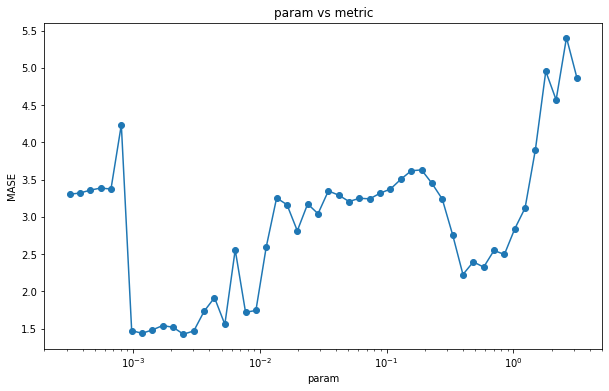

In [64]:
check_hyperparams(midatl_train, midatl_test)

12:24:47 - cmdstanpy - INFO - Chain [1] start processing
12:24:47 - cmdstanpy - INFO - Chain [1] done processing
12:24:48 - cmdstanpy - INFO - Chain [1] start processing
12:24:48 - cmdstanpy - INFO - Chain [1] done processing
12:24:49 - cmdstanpy - INFO - Chain [1] start processing
12:24:49 - cmdstanpy - INFO - Chain [1] done processing
12:24:50 - cmdstanpy - INFO - Chain [1] start processing
12:24:50 - cmdstanpy - INFO - Chain [1] done processing
12:24:51 - cmdstanpy - INFO - Chain [1] start processing
12:24:51 - cmdstanpy - INFO - Chain [1] done processing
12:24:52 - cmdstanpy - INFO - Chain [1] start processing
12:24:52 - cmdstanpy - INFO - Chain [1] done processing
12:24:53 - cmdstanpy - INFO - Chain [1] start processing
12:24:53 - cmdstanpy - INFO - Chain [1] done processing
12:24:54 - cmdstanpy - INFO - Chain [1] start processing
12:24:54 - cmdstanpy - INFO - Chain [1] done processing
12:24:55 - cmdstanpy - INFO - Chain [1] start processing
12:24:55 - cmdstanpy - INFO - Chain [1]

Lowest 5 MASEs and params:
param: 11.513953993264469, MASE: 2.998961897301696
param: 1.5998587196060574, MASE: 3.005029756701365
param: 5689.866029018293, MASE: 3.100653025133251
param: 15.264179671752334, MASE: 3.104006295696704
param: 0.017575106248547922, MASE: 3.1410186878011164


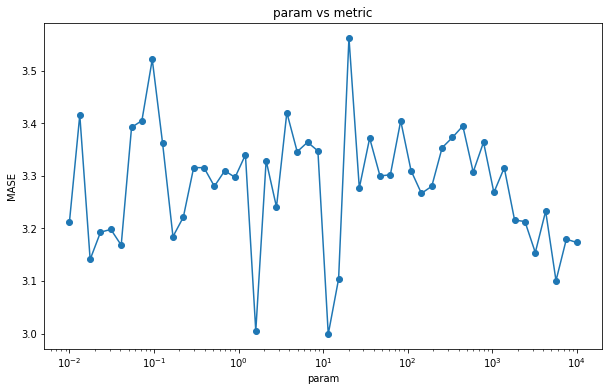

In [65]:
check_hyperparams(midatl_train, midatl_test, param = 'seasonality_prior_scale')

12:28:35 - cmdstanpy - INFO - Chain [1] start processing
12:28:35 - cmdstanpy - INFO - Chain [1] done processing
12:28:35 - cmdstanpy - INFO - Chain [1] start processing
12:28:36 - cmdstanpy - INFO - Chain [1] done processing
12:28:36 - cmdstanpy - INFO - Chain [1] start processing
12:28:36 - cmdstanpy - INFO - Chain [1] done processing
12:28:37 - cmdstanpy - INFO - Chain [1] start processing
12:28:37 - cmdstanpy - INFO - Chain [1] done processing
12:28:37 - cmdstanpy - INFO - Chain [1] start processing
12:28:37 - cmdstanpy - INFO - Chain [1] done processing
12:28:38 - cmdstanpy - INFO - Chain [1] start processing
12:28:38 - cmdstanpy - INFO - Chain [1] done processing
12:28:39 - cmdstanpy - INFO - Chain [1] start processing
12:28:39 - cmdstanpy - INFO - Chain [1] done processing
12:28:39 - cmdstanpy - INFO - Chain [1] start processing
12:28:39 - cmdstanpy - INFO - Chain [1] done processing
12:28:40 - cmdstanpy - INFO - Chain [1] start processing
12:28:40 - cmdstanpy - INFO - Chain [1]

Lowest 5 MASEs and params:
param: 310.3392703374392, MASE: 2.7026469865375966
param: 192.16463678960986, MASE: 2.7403445891100198
param: 109.85411419875595, MASE: 2.810795407769314
param: 364.1031949310677, MASE: 2.8212832950546542
param: 244.20530945486522, MASE: 2.845640089779011


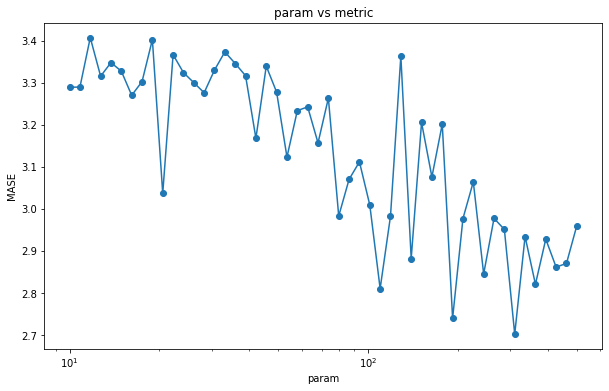

In [70]:
check_hyperparams(midatl_train, midatl_test, param = 'n_changepoints')

12:30:14 - cmdstanpy - INFO - Chain [1] start processing
12:30:14 - cmdstanpy - INFO - Chain [1] done processing
12:30:15 - cmdstanpy - INFO - Chain [1] start processing
12:30:15 - cmdstanpy - INFO - Chain [1] done processing
12:30:15 - cmdstanpy - INFO - Chain [1] start processing
12:30:16 - cmdstanpy - INFO - Chain [1] done processing
12:30:16 - cmdstanpy - INFO - Chain [1] start processing
12:30:16 - cmdstanpy - INFO - Chain [1] done processing
12:30:17 - cmdstanpy - INFO - Chain [1] start processing
12:30:17 - cmdstanpy - INFO - Chain [1] done processing
12:30:18 - cmdstanpy - INFO - Chain [1] start processing
12:30:18 - cmdstanpy - INFO - Chain [1] done processing
12:30:18 - cmdstanpy - INFO - Chain [1] start processing
12:30:18 - cmdstanpy - INFO - Chain [1] done processing
12:30:19 - cmdstanpy - INFO - Chain [1] start processing
12:30:19 - cmdstanpy - INFO - Chain [1] done processing
12:30:20 - cmdstanpy - INFO - Chain [1] start processing
12:30:20 - cmdstanpy - INFO - Chain [1]

changepoint_prior_scale:  0.0014
seasonality_prior_scale:  0.018
n_changepoints:  13


/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects inste

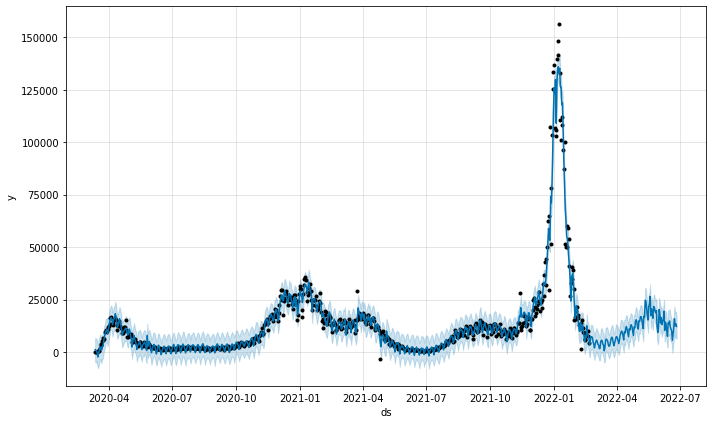

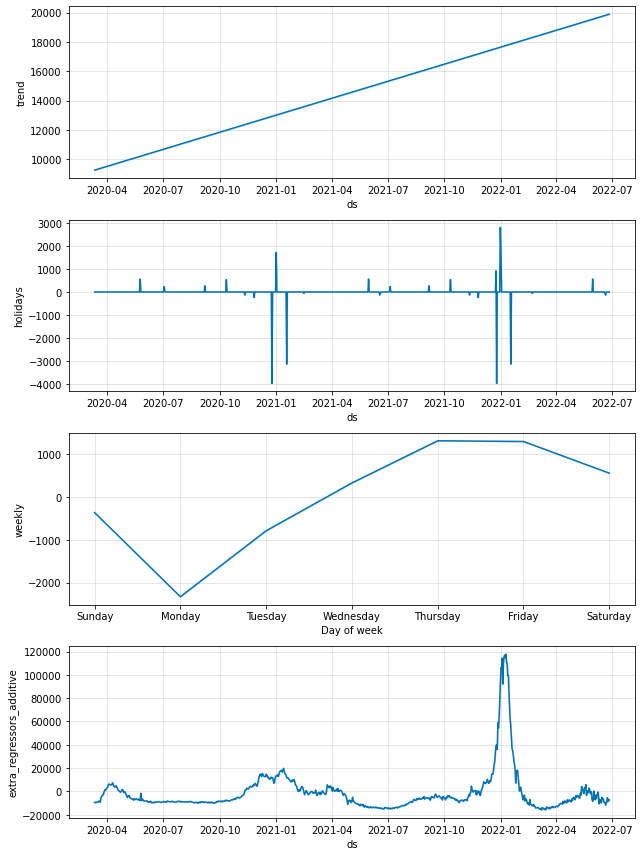

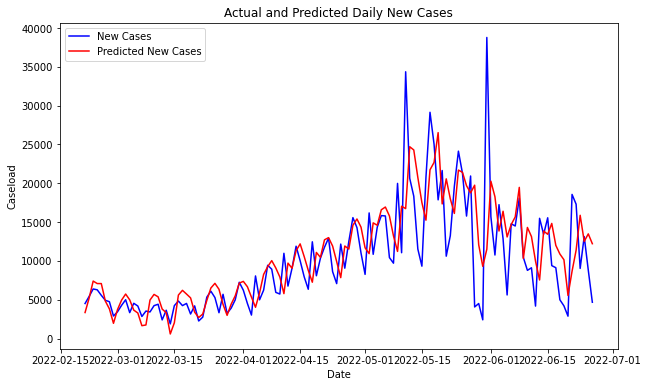

MAE: 3282.265849955241
RMSE: 4962.533861775752
MSE: 24626742.329270955
MASE: 1.4191464408619474


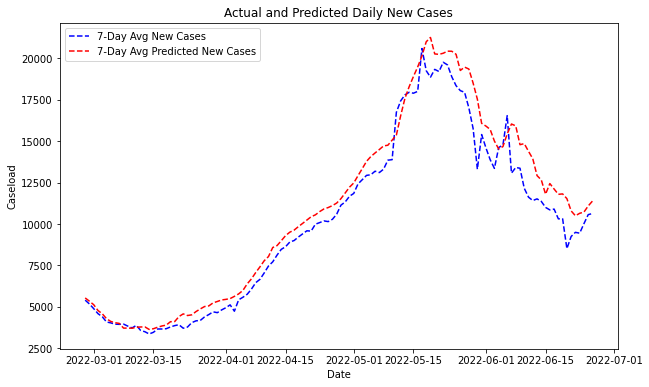

7-Day Avg MAE: 902.1701345388999
7-Day Avg RMSE: 1166.8427593148197
7-Day Avg MSE: 1361522.0249654222
7-Day Avg MASE: 2.175820849574676
7-Day Avg MAPE: 0.09121483786251734


In [71]:
model_atl, models_atl, forecast_midatl, fig1, fig2 = search_prophet(midatl_train, midatl_test, changepoints=[.0025, .0012, .003, .00098, .0014], seasonalities=[11.5, 1.6, 5700, 15, .018], n_changepoints_vals=[310, 19, 110, 244,13 ])

12:26:34 - cmdstanpy - INFO - Chain [1] start processing
12:26:34 - cmdstanpy - INFO - Chain [1] done processing
12:26:35 - cmdstanpy - INFO - Chain [1] start processing
12:26:35 - cmdstanpy - INFO - Chain [1] done processing
12:26:36 - cmdstanpy - INFO - Chain [1] start processing
12:26:36 - cmdstanpy - INFO - Chain [1] done processing
12:26:36 - cmdstanpy - INFO - Chain [1] start processing
12:26:36 - cmdstanpy - INFO - Chain [1] done processing
12:26:37 - cmdstanpy - INFO - Chain [1] start processing
12:26:37 - cmdstanpy - INFO - Chain [1] done processing
12:26:37 - cmdstanpy - INFO - Chain [1] start processing
12:26:37 - cmdstanpy - INFO - Chain [1] done processing
12:26:38 - cmdstanpy - INFO - Chain [1] start processing
12:26:38 - cmdstanpy - INFO - Chain [1] done processing
12:26:38 - cmdstanpy - INFO - Chain [1] start processing
12:26:38 - cmdstanpy - INFO - Chain [1] done processing
12:26:39 - cmdstanpy - INFO - Chain [1] start processing
12:26:39 - cmdstanpy - INFO - Chain [1]

changepoint_prior_scale:  0.001
seasonality_prior_scale:  500
n_changepoints:  50


/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects inste

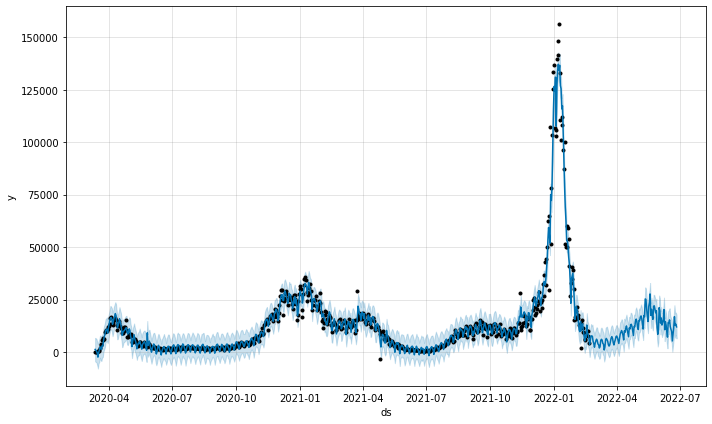

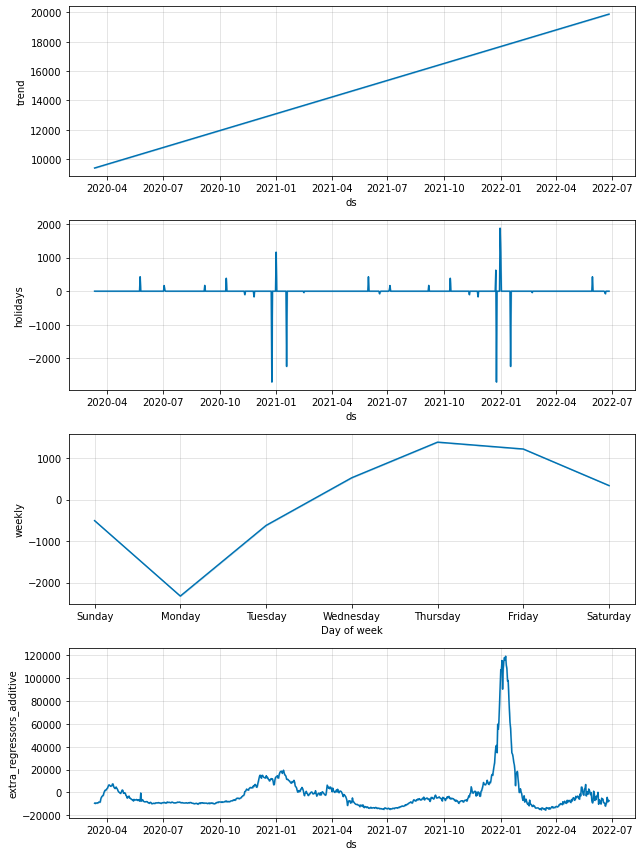

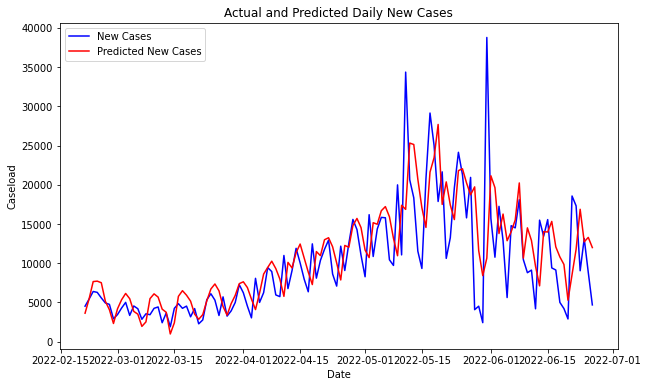

MAE: 3396.2733902156997
RMSE: 5074.433939730738
MSE: 25749879.808691215
MASE: 1.4684396432983868


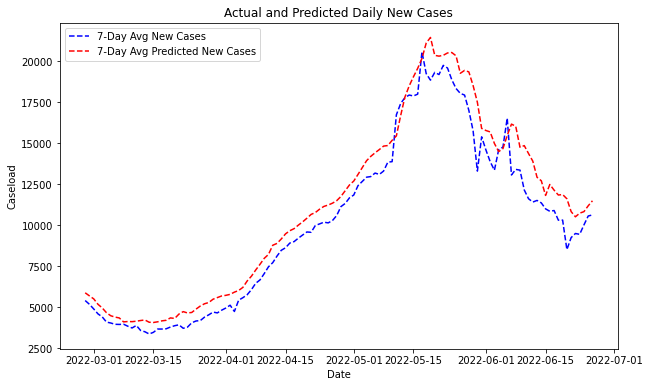

7-Day Avg MAE: 1056.0142257552816
7-Day Avg RMSE: 1257.6641416757589
7-Day Avg MSE: 1581719.0932570233
7-Day Avg MASE: 2.5468563875927415
7-Day Avg MAPE: 0.1186649681354341


In [67]:
model_atl, models_atl, forecast_midatl, fig1, fig2 = search_prophet(midatl_train, midatl_test)

# Mountain

12:34:36 - cmdstanpy - INFO - Chain [1] start processing
12:34:36 - cmdstanpy - INFO - Chain [1] done processing
12:34:36 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
12:34:36 - cmdstanpy - INFO - Chain [1] start processing
12:34:39 - cmdstanpy - INFO - Chain [1] done processing
12:34:40 - cmdstanpy - INFO - Chain [1] start processing
12:34:40 - cmdstanpy - INFO - Chain [1] done processing
12:34:40 - cmdstanpy - INFO - Chain [1] start processing
12:34:40 - cmdstanpy - INFO - Chain [1] done processing
12:34:41 - cmdstanpy - INFO - Chain [1] start processing
12:34:41 - cmdstanpy - INFO - Chain [1] done processing
12:34:41 - cmdstanpy - INFO - Chain [1] start processing
12:34:41 - cmdstanpy - INFO - Chain [1] done processing
12:34:42 - cmdstanpy - INFO - Chain [1] start processing
12:34:42 - cmdstanpy - INFO - Chain [1] done processing
12:34:42 - cmdstanpy - INFO - Chain [1] start process

Lowest 5 MASEs and params:
param: 0.0006707035611184306, MASE: 0.7875339567162734
param: 0.0005557736586486875, MASE: 0.7993297059609202
param: 0.0004605378255822417, MASE: 0.8765622526174194
param: 0.0008094001216083124, MASE: 0.9078632508752794
param: 0.0009767781100894892, MASE: 0.9464728285023295


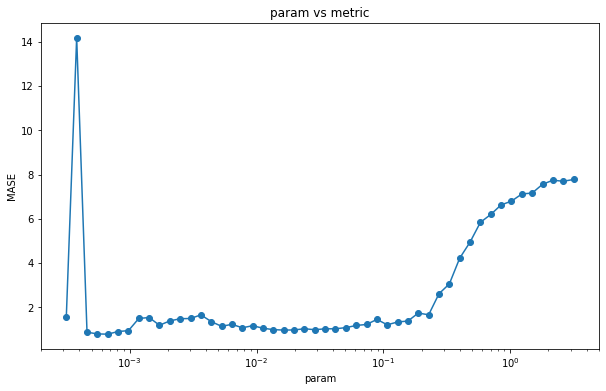

In [74]:
check_hyperparams(mount_train, mount_test)

00:46:39 - cmdstanpy - INFO - Chain [1] start processing
00:46:40 - cmdstanpy - INFO - Chain [1] done processing
00:46:40 - cmdstanpy - INFO - Chain [1] start processing
00:46:40 - cmdstanpy - INFO - Chain [1] done processing
00:46:41 - cmdstanpy - INFO - Chain [1] start processing
00:46:41 - cmdstanpy - INFO - Chain [1] done processing
00:46:42 - cmdstanpy - INFO - Chain [1] start processing
00:46:42 - cmdstanpy - INFO - Chain [1] done processing
00:46:42 - cmdstanpy - INFO - Chain [1] start processing
00:46:43 - cmdstanpy - INFO - Chain [1] done processing
00:46:43 - cmdstanpy - INFO - Chain [1] start processing
00:46:43 - cmdstanpy - INFO - Chain [1] done processing
00:46:44 - cmdstanpy - INFO - Chain [1] start processing
00:46:44 - cmdstanpy - INFO - Chain [1] done processing
00:46:44 - cmdstanpy - INFO - Chain [1] start processing
00:46:44 - cmdstanpy - INFO - Chain [1] done processing
00:46:45 - cmdstanpy - INFO - Chain [1] start processing
00:46:45 - cmdstanpy - INFO - Chain [1]

Lowest 5 MASEs and params:
param: 39.06939937054613, MASE: 0.9719019145265709
param: 0.1151395399326447, MASE: 0.9758909071528146
param: 0.04498432668969444, MASE: 0.9796419634314724
param: 0.7543120063354615, MASE: 0.9836368902263309
param: 0.030888435964774818, MASE: 0.9966675300856871


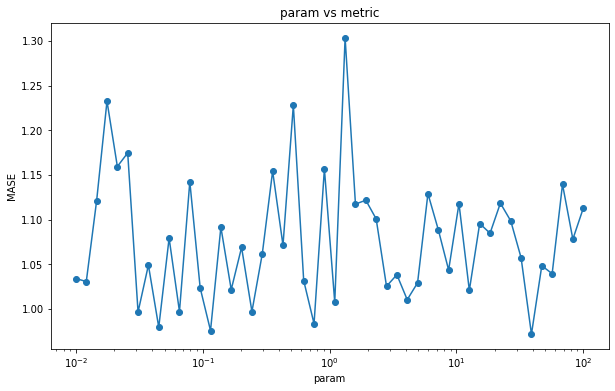

In [26]:
check_hyperparams(mount_train, mount_test, param = 'seasonality_prior_scale')

00:48:21 - cmdstanpy - INFO - Chain [1] start processing
00:48:22 - cmdstanpy - INFO - Chain [1] done processing
00:48:22 - cmdstanpy - INFO - Chain [1] start processing
00:48:22 - cmdstanpy - INFO - Chain [1] done processing
00:48:23 - cmdstanpy - INFO - Chain [1] start processing
00:48:23 - cmdstanpy - INFO - Chain [1] done processing
00:48:23 - cmdstanpy - INFO - Chain [1] start processing
00:48:24 - cmdstanpy - INFO - Chain [1] done processing
00:48:24 - cmdstanpy - INFO - Chain [1] start processing
00:48:24 - cmdstanpy - INFO - Chain [1] done processing
00:48:24 - cmdstanpy - INFO - Chain [1] start processing
00:48:25 - cmdstanpy - INFO - Chain [1] done processing
00:48:25 - cmdstanpy - INFO - Chain [1] start processing
00:48:25 - cmdstanpy - INFO - Chain [1] done processing
00:48:26 - cmdstanpy - INFO - Chain [1] start processing
00:48:26 - cmdstanpy - INFO - Chain [1] done processing
00:48:26 - cmdstanpy - INFO - Chain [1] start processing
00:48:27 - cmdstanpy - INFO - Chain [1]

Lowest 5 MASEs and params:
param: 79.06043210907697, MASE: 0.9685028394828122
param: 65.51285568595509, MASE: 0.976543511114258
param: 86.85113737513525, MASE: 0.9765914286676665
param: 95.40954763499938, MASE: 0.9766580539560544
param: 28.11768697974231, MASE: 0.9769917787921847


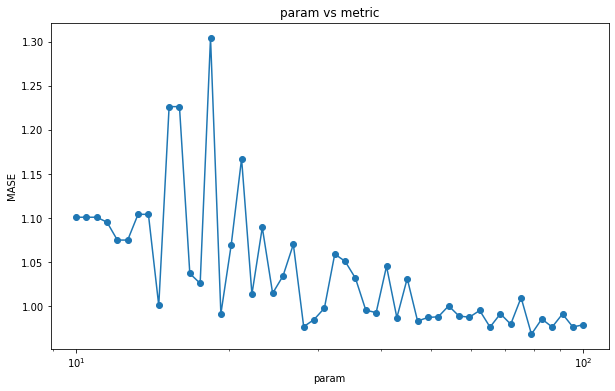

In [27]:
check_hyperparams(mount_train, mount_test, param = 'n_changepoints')

00:50:10 - cmdstanpy - INFO - Chain [1] start processing
00:50:10 - cmdstanpy - INFO - Chain [1] done processing
00:50:10 - cmdstanpy - INFO - Chain [1] start processing
00:50:10 - cmdstanpy - INFO - Chain [1] done processing
00:50:11 - cmdstanpy - INFO - Chain [1] start processing
00:50:11 - cmdstanpy - INFO - Chain [1] done processing
00:50:11 - cmdstanpy - INFO - Chain [1] start processing
00:50:11 - cmdstanpy - INFO - Chain [1] done processing
00:50:11 - cmdstanpy - INFO - Chain [1] start processing
00:50:12 - cmdstanpy - INFO - Chain [1] done processing
00:50:12 - cmdstanpy - INFO - Chain [1] start processing
00:50:12 - cmdstanpy - INFO - Chain [1] done processing
00:50:12 - cmdstanpy - INFO - Chain [1] start processing
00:50:12 - cmdstanpy - INFO - Chain [1] done processing
00:50:13 - cmdstanpy - INFO - Chain [1] start processing
00:50:13 - cmdstanpy - INFO - Chain [1] done processing
00:50:13 - cmdstanpy - INFO - Chain [1] start processing
00:50:13 - cmdstanpy - INFO - Chain [1]

changepoint_prior_scale:  0.00056
seasonality_prior_scale:  0.75
n_changepoints:  87


/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects inste

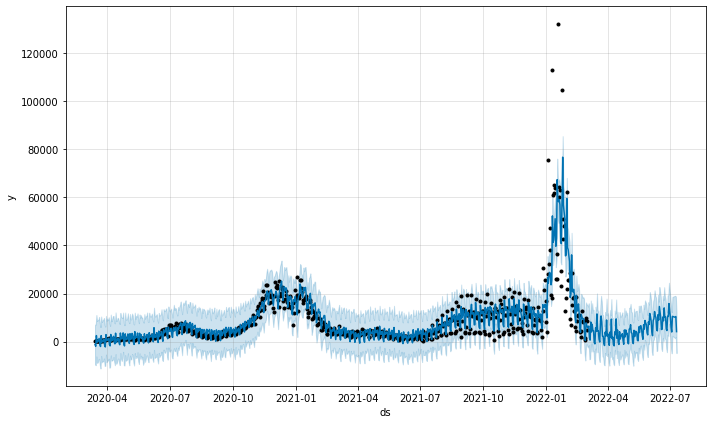

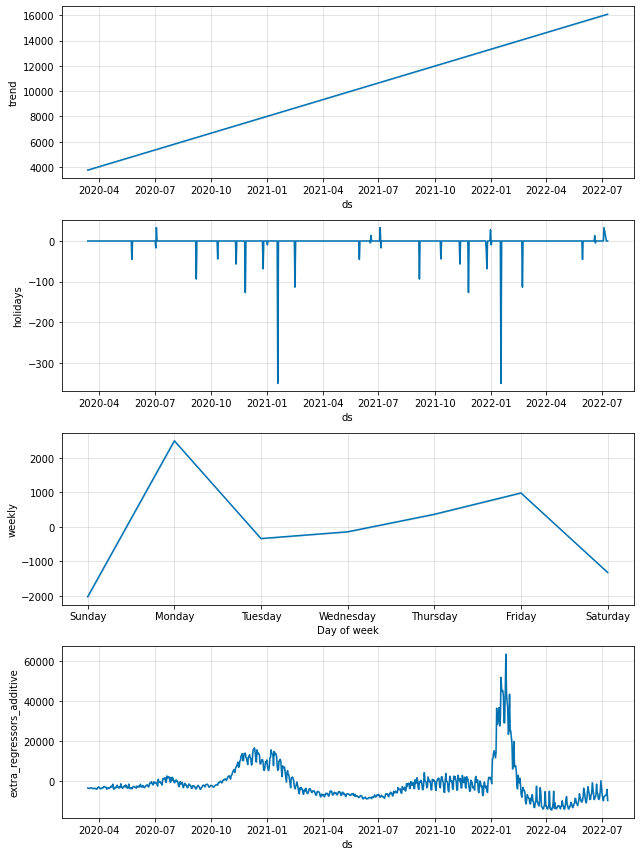

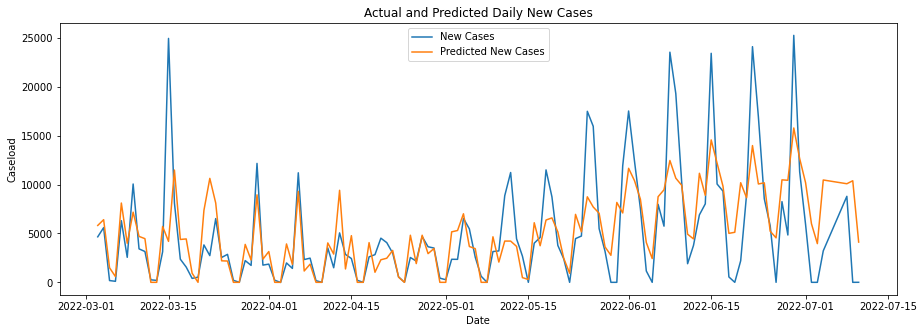

MAE: 2596.0609429199435
RMSE: 4034.00553263719
MSE: 16273200.637347456
MASE: 0.769019496431687


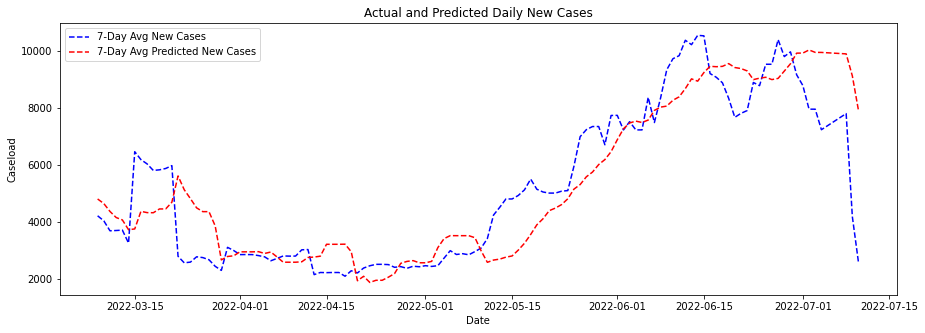

7-Day Avg MAE: 978.7617695870262
7-Day Avg RMSE: 1314.2961370271623
7-Day Avg MSE: 1727374.3358045213
7-Day Avg MASE: 2.764798124263683
7-Day Avg MAPE: 0.2264439755930224


In [28]:
model_mount, models_mount, forecast_mount, fig1, fig2 = search_prophet(mount_train, mount_test, changepoints=[.00067, .00056, .1, .00046, .015], seasonalities=[2.1, .13, 36, .045, .75], n_changepoints_vals=[65, 80, 95, 28, 87])

12:33:47 - cmdstanpy - INFO - Chain [1] start processing
12:33:47 - cmdstanpy - INFO - Chain [1] done processing
12:33:48 - cmdstanpy - INFO - Chain [1] start processing
12:33:48 - cmdstanpy - INFO - Chain [1] done processing
12:33:49 - cmdstanpy - INFO - Chain [1] start processing
12:33:49 - cmdstanpy - INFO - Chain [1] done processing
12:33:49 - cmdstanpy - INFO - Chain [1] start processing
12:33:49 - cmdstanpy - INFO - Chain [1] done processing
12:33:50 - cmdstanpy - INFO - Chain [1] start processing
12:33:50 - cmdstanpy - INFO - Chain [1] done processing
12:33:51 - cmdstanpy - INFO - Chain [1] start processing
12:33:51 - cmdstanpy - INFO - Chain [1] done processing
12:33:52 - cmdstanpy - INFO - Chain [1] start processing
12:33:52 - cmdstanpy - INFO - Chain [1] done processing
12:33:52 - cmdstanpy - INFO - Chain [1] start processing
12:33:53 - cmdstanpy - INFO - Chain [1] done processing
12:33:53 - cmdstanpy - INFO - Chain [1] start processing
12:33:53 - cmdstanpy - INFO - Chain [1]

changepoint_prior_scale:  0.01
seasonality_prior_scale:  500
n_changepoints:  50


/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects inste

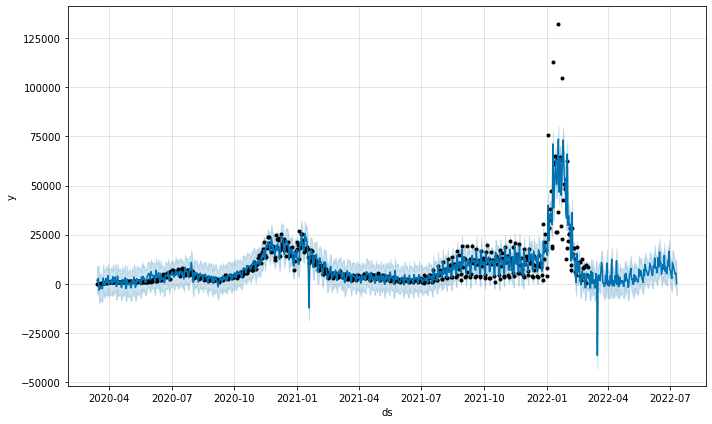

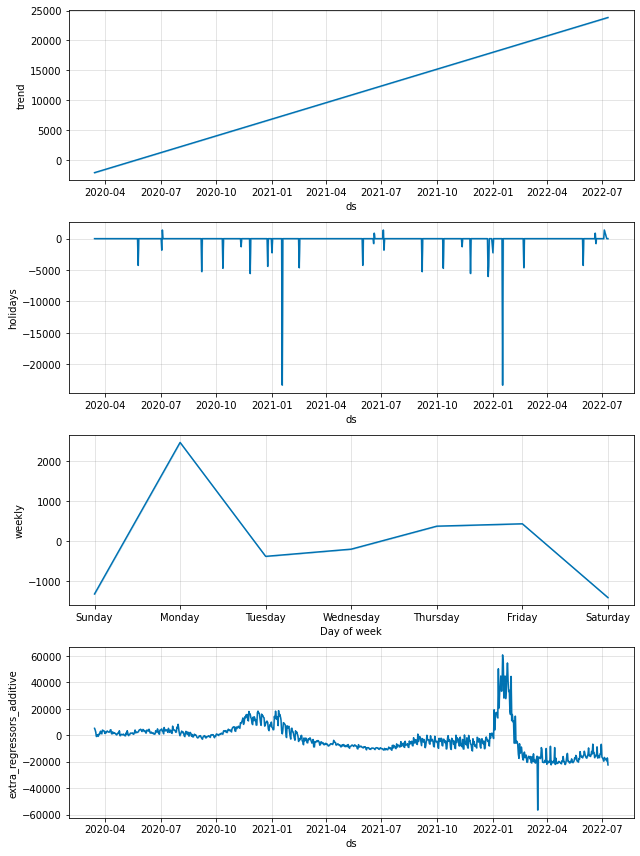

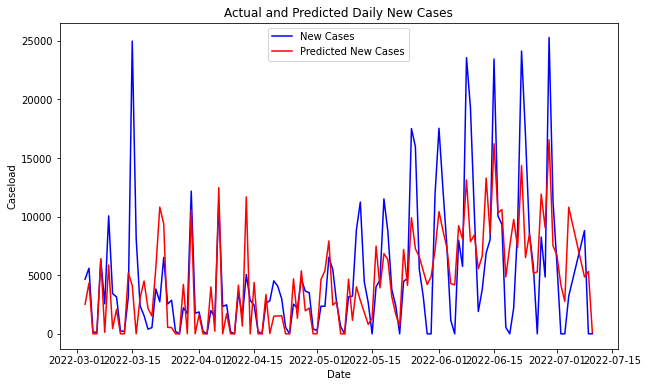

MAE: 2831.2972455671284
RMSE: 4190.398612818507
MSE: 17559440.534311265
MASE: 0.8387024919320621


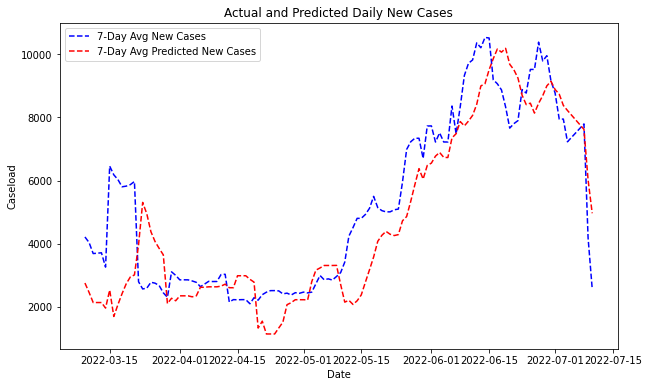

7-Day Avg MAE: 1138.8993763839615
7-Day Avg RMSE: 1446.84878231214
7-Day Avg MSE: 2093371.398878122
7-Day Avg MASE: 3.2171535070071804
7-Day Avg MAPE: 0.2552735274624178


In [73]:
model_mount, models_mount, forecast_mount, fig1, fig2 = search_prophet(mount_train, mount_test)

# New England

13:03:09 - cmdstanpy - INFO - Chain [1] start processing
13:03:09 - cmdstanpy - INFO - Chain [1] done processing
13:03:09 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
13:03:09 - cmdstanpy - INFO - Chain [1] start processing
13:03:11 - cmdstanpy - INFO - Chain [1] done processing
13:03:12 - cmdstanpy - INFO - Chain [1] start processing
13:03:12 - cmdstanpy - INFO - Chain [1] done processing
13:03:12 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
13:03:12 - cmdstanpy - INFO - Chain [1] start processing
13:03:15 - cmdstanpy - INFO - Chain [1] done processing
13:03:16 - cmdstanpy - INFO - Chain [1] start processing
13:03:16 - cmdstanpy - INFO - Chain [1] done processing
13:03:16 - cmdstanpy - INFO - Chain [1] start processing
13:03:16 - cmdstanpy - INFO - Chain [1] done processing
13:03:17 -

Lowest 5 MASEs and params:
param: 0.019765980717016327, MASE: 0.669592743444646
param: 0.01357228782971653, MASE: 0.6762454519532543
param: 0.011246578221198195, MASE: 0.7140913488499218
param: 0.0006707035611184306, MASE: 0.7953127958923616
param: 0.016378937069540637, MASE: 0.8302477173972272


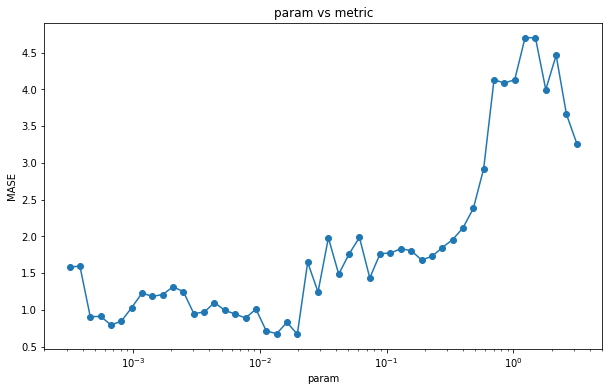

In [78]:
check_hyperparams(ne_train, ne_test)

13:04:16 - cmdstanpy - INFO - Chain [1] start processing
13:04:16 - cmdstanpy - INFO - Chain [1] done processing
13:04:16 - cmdstanpy - INFO - Chain [1] start processing
13:04:16 - cmdstanpy - INFO - Chain [1] done processing
13:04:17 - cmdstanpy - INFO - Chain [1] start processing
13:04:17 - cmdstanpy - INFO - Chain [1] done processing
13:04:17 - cmdstanpy - INFO - Chain [1] start processing
13:04:18 - cmdstanpy - INFO - Chain [1] done processing
13:04:18 - cmdstanpy - INFO - Chain [1] start processing
13:04:18 - cmdstanpy - INFO - Chain [1] done processing
13:04:18 - cmdstanpy - INFO - Chain [1] start processing
13:04:19 - cmdstanpy - INFO - Chain [1] done processing
13:04:19 - cmdstanpy - INFO - Chain [1] start processing
13:04:19 - cmdstanpy - INFO - Chain [1] done processing
13:04:20 - cmdstanpy - INFO - Chain [1] start processing
13:04:20 - cmdstanpy - INFO - Chain [1] done processing
13:04:20 - cmdstanpy - INFO - Chain [1] start processing
13:04:20 - cmdstanpy - INFO - Chain [1]

Lowest 5 MASEs and params:
param: 1842.0699693267163, MASE: 1.0346561966544179
param: 15.264179671752334, MASE: 1.3070895539733938
param: 82.86427728546842, MASE: 1.3945364825867297
param: 1389.4954943731361, MASE: 1.4248847701371803
param: 4.941713361323833, MASE: 1.4602805409808086


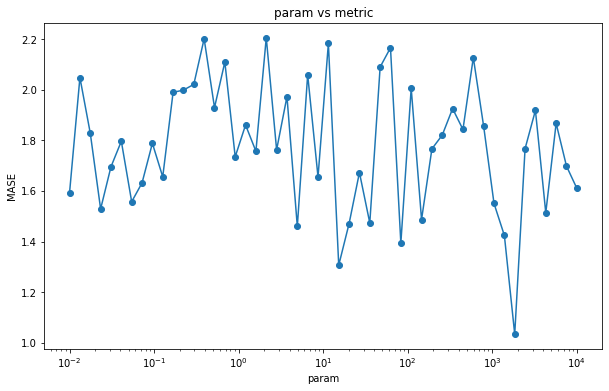

In [79]:
check_hyperparams(ne_train, ne_test, param = 'seasonality_prior_scale')

13:04:43 - cmdstanpy - INFO - Chain [1] start processing
13:04:43 - cmdstanpy - INFO - Chain [1] done processing
13:04:44 - cmdstanpy - INFO - Chain [1] start processing
13:04:44 - cmdstanpy - INFO - Chain [1] done processing
13:04:44 - cmdstanpy - INFO - Chain [1] start processing
13:04:44 - cmdstanpy - INFO - Chain [1] done processing
13:04:45 - cmdstanpy - INFO - Chain [1] start processing
13:04:45 - cmdstanpy - INFO - Chain [1] done processing
13:04:45 - cmdstanpy - INFO - Chain [1] start processing
13:04:45 - cmdstanpy - INFO - Chain [1] done processing
13:04:46 - cmdstanpy - INFO - Chain [1] start processing
13:04:46 - cmdstanpy - INFO - Chain [1] done processing
13:04:46 - cmdstanpy - INFO - Chain [1] start processing
13:04:47 - cmdstanpy - INFO - Chain [1] done processing
13:04:47 - cmdstanpy - INFO - Chain [1] start processing
13:04:47 - cmdstanpy - INFO - Chain [1] done processing
13:04:47 - cmdstanpy - INFO - Chain [1] start processing
13:04:48 - cmdstanpy - INFO - Chain [1]

Lowest 5 MASEs and params:
param: 264.5141928287878, MASE: 0.6665032295976683
param: 225.45570250193435, MASE: 0.6741160936966981
param: 501.18723362727246, MASE: 0.6854562412283881
param: 462.7070561843051, MASE: 0.6897821742704613
param: 286.5120269663782, MASE: 0.7214994192855883


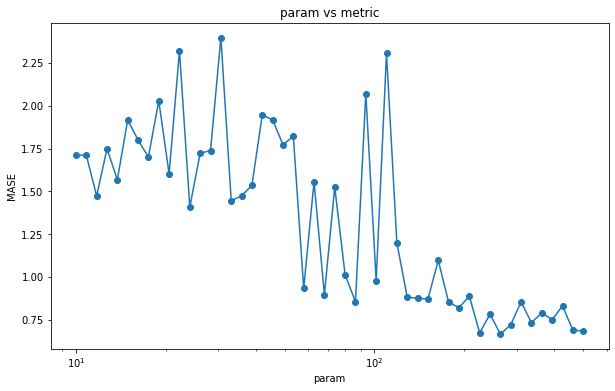

In [80]:
check_hyperparams(ne_train, ne_test, param = 'n_changepoints')

13:06:28 - cmdstanpy - INFO - Chain [1] start processing
13:06:28 - cmdstanpy - INFO - Chain [1] done processing
13:06:28 - cmdstanpy - INFO - Chain [1] start processing
13:06:28 - cmdstanpy - INFO - Chain [1] done processing
13:06:29 - cmdstanpy - INFO - Chain [1] start processing
13:06:29 - cmdstanpy - INFO - Chain [1] done processing
13:06:29 - cmdstanpy - INFO - Chain [1] start processing
13:06:29 - cmdstanpy - INFO - Chain [1] done processing
13:06:30 - cmdstanpy - INFO - Chain [1] start processing
13:06:30 - cmdstanpy - INFO - Chain [1] done processing
13:06:30 - cmdstanpy - INFO - Chain [1] start processing
13:06:30 - cmdstanpy - INFO - Chain [1] done processing
13:06:31 - cmdstanpy - INFO - Chain [1] start processing
13:06:31 - cmdstanpy - INFO - Chain [1] done processing
13:06:31 - cmdstanpy - INFO - Chain [1] start processing
13:06:31 - cmdstanpy - INFO - Chain [1] done processing
13:06:32 - cmdstanpy - INFO - Chain [1] start processing
13:06:32 - cmdstanpy - INFO - Chain [1]

changepoint_prior_scale:  0.02
seasonality_prior_scale:  4.9
n_changepoints:  286


/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects inste

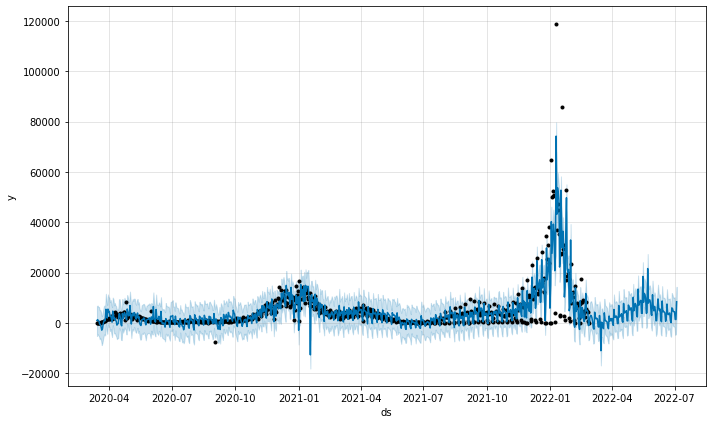

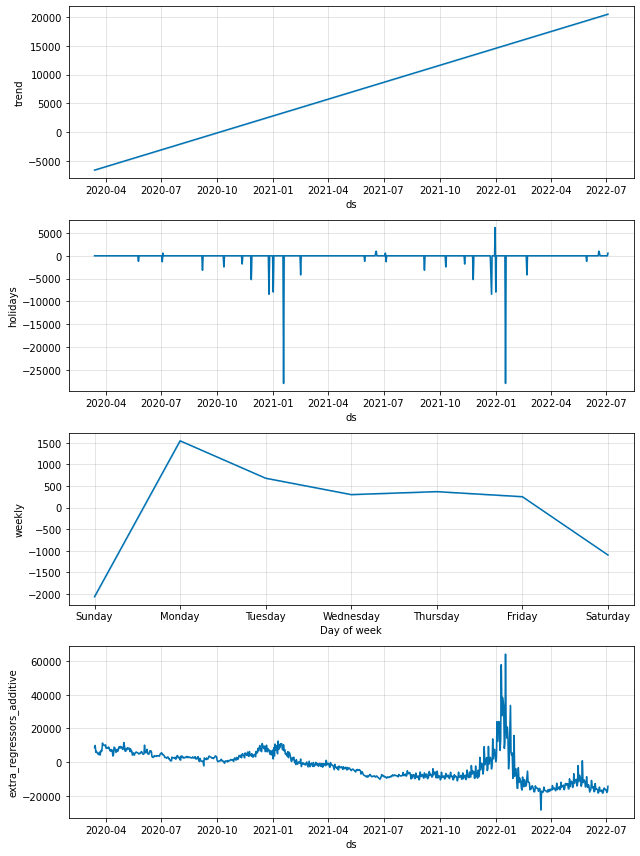

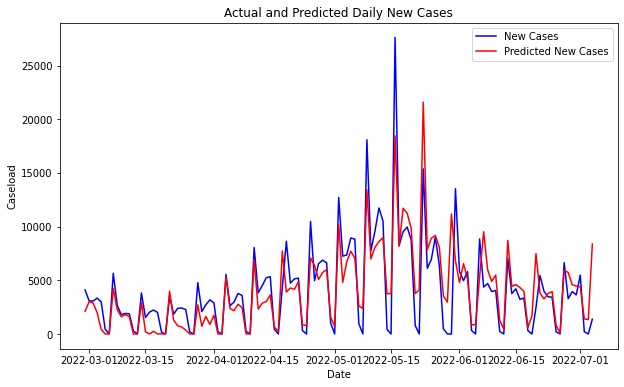

MAE: 1592.2579253028105
RMSE: 2372.473522797321
MSE: 5628630.61637433
MASE: 0.583193570783527


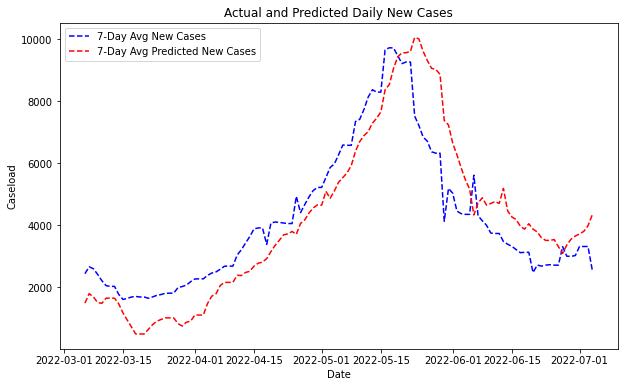

7-Day Avg MAE: 967.3280149675452
7-Day Avg RMSE: 1133.7845629556484
7-Day Avg MSE: 1285467.4351965308
7-Day Avg MASE: 4.422453178421678
7-Day Avg MAPE: 0.28163904322625327


In [82]:
model_ne, models_ne, forecast_ne, fig1, fig2 = search_prophet(ne_train, ne_test, changepoints=[.02, .014, .011, .00067, .016], seasonalities=[1800, 15, 83, 1400, 4.9], n_changepoints_vals=[265, 225, 501, 463, 286])

13:05:16 - cmdstanpy - INFO - Chain [1] start processing
13:05:16 - cmdstanpy - INFO - Chain [1] done processing
13:05:17 - cmdstanpy - INFO - Chain [1] start processing
13:05:17 - cmdstanpy - INFO - Chain [1] done processing
13:05:17 - cmdstanpy - INFO - Chain [1] start processing
13:05:17 - cmdstanpy - INFO - Chain [1] done processing
13:05:17 - cmdstanpy - INFO - Chain [1] start processing
13:05:18 - cmdstanpy - INFO - Chain [1] done processing
13:05:18 - cmdstanpy - INFO - Chain [1] start processing
13:05:18 - cmdstanpy - INFO - Chain [1] done processing
13:05:18 - cmdstanpy - INFO - Chain [1] start processing
13:05:18 - cmdstanpy - INFO - Chain [1] done processing
13:05:19 - cmdstanpy - INFO - Chain [1] start processing
13:05:19 - cmdstanpy - INFO - Chain [1] done processing
13:05:19 - cmdstanpy - INFO - Chain [1] start processing
13:05:19 - cmdstanpy - INFO - Chain [1] done processing
13:05:20 - cmdstanpy - INFO - Chain [1] start processing
13:05:20 - cmdstanpy - INFO - Chain [1]

changepoint_prior_scale:  0.001
seasonality_prior_scale:  500
n_changepoints:  50


/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects inste

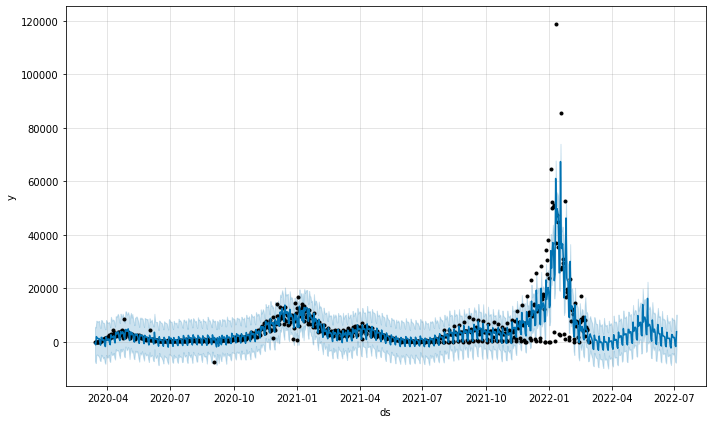

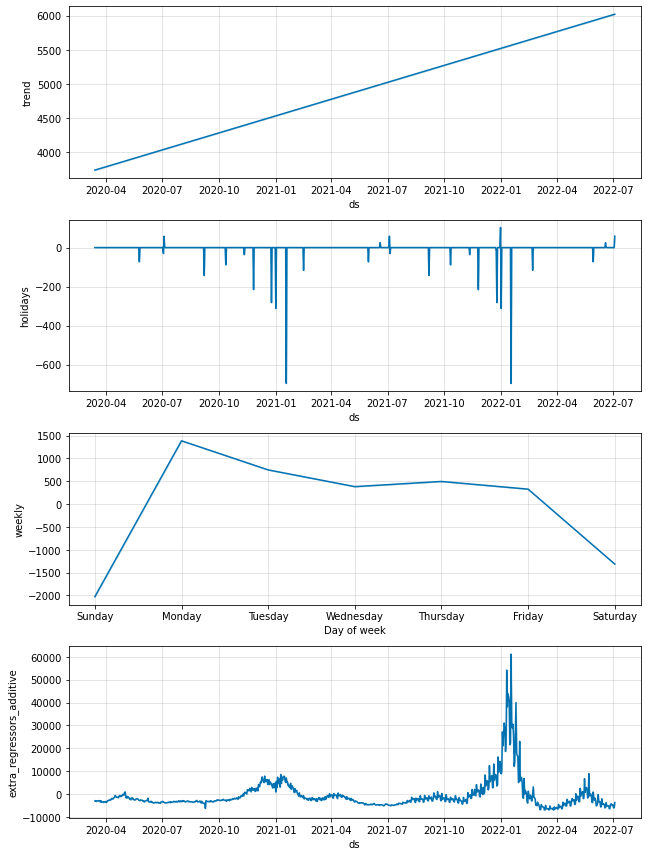

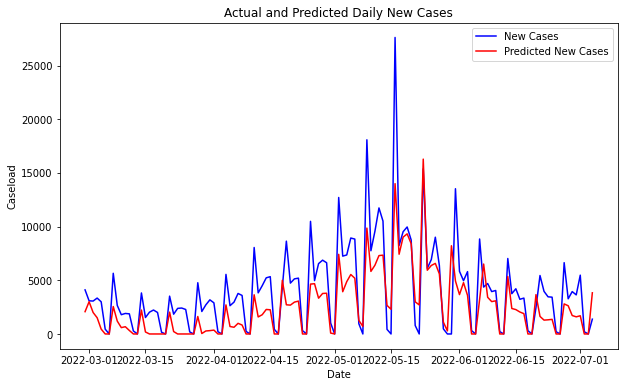

MAE: 1947.441659069548
RMSE: 2778.070633868264
MSE: 7717676.446761217
MASE: 0.7132861058483192


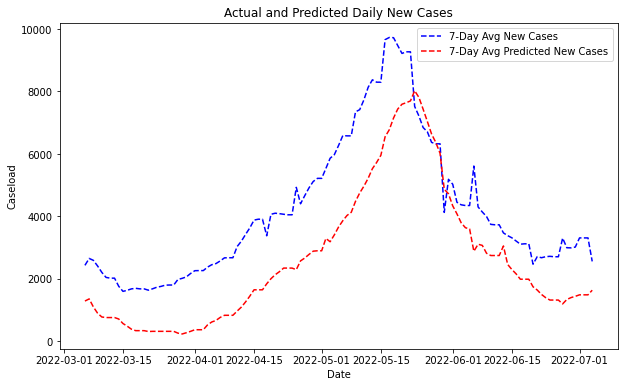

7-Day Avg MAE: 1615.6617037354338
7-Day Avg RMSE: 1751.999846012529
7-Day Avg MSE: 3069503.460427925
7-Day Avg MASE: 7.386520524972784
7-Day Avg MAPE: 0.470423442704516


In [81]:
model_ne, models_ne, forecast_ne, fig1, fig2 = search_prophet(ne_train, ne_test)

# Pacific

13:09:48 - cmdstanpy - INFO - Chain [1] start processing
13:09:48 - cmdstanpy - INFO - Chain [1] done processing
13:09:48 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
13:09:48 - cmdstanpy - INFO - Chain [1] start processing
13:09:50 - cmdstanpy - INFO - Chain [1] done processing
13:09:50 - cmdstanpy - INFO - Chain [1] start processing
13:09:50 - cmdstanpy - INFO - Chain [1] done processing
13:09:50 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
13:09:51 - cmdstanpy - INFO - Chain [1] start processing
13:09:55 - cmdstanpy - INFO - Chain [1] done processing
13:09:56 - cmdstanpy - INFO - Chain [1] start processing
13:09:56 - cmdstanpy - INFO - Chain [1] done processing
13:09:56 - cmdstanpy - INFO - Chain [1] start processing
13:09:56 - cmdstanpy - INFO - Chain [1] done processing
13:09:56 -

Lowest 5 MASEs and params:
param: 0.061054022965853265, MASE: 1.16187267715317
param: 0.08891593339164633, MASE: 1.168250275083507
param: 0.05059197488435822, MASE: 1.1809452498344843
param: 0.04192267435236914, MASE: 1.1950632571499058
param: 0.016378937069540637, MASE: 1.1977209531945414


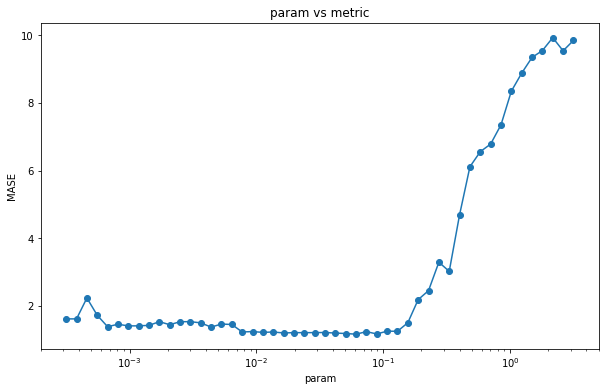

In [83]:
check_hyperparams(pac_train, pac_test)

13:11:10 - cmdstanpy - INFO - Chain [1] start processing
13:11:10 - cmdstanpy - INFO - Chain [1] done processing
13:11:11 - cmdstanpy - INFO - Chain [1] start processing
13:11:11 - cmdstanpy - INFO - Chain [1] done processing
13:11:11 - cmdstanpy - INFO - Chain [1] start processing
13:11:11 - cmdstanpy - INFO - Chain [1] done processing
13:11:12 - cmdstanpy - INFO - Chain [1] start processing
13:11:12 - cmdstanpy - INFO - Chain [1] done processing
13:11:13 - cmdstanpy - INFO - Chain [1] start processing
13:11:13 - cmdstanpy - INFO - Chain [1] done processing
13:11:13 - cmdstanpy - INFO - Chain [1] start processing
13:11:13 - cmdstanpy - INFO - Chain [1] done processing
13:11:14 - cmdstanpy - INFO - Chain [1] start processing
13:11:14 - cmdstanpy - INFO - Chain [1] done processing
13:11:14 - cmdstanpy - INFO - Chain [1] start processing
13:11:14 - cmdstanpy - INFO - Chain [1] done processing
13:11:15 - cmdstanpy - INFO - Chain [1] start processing
13:11:15 - cmdstanpy - INFO - Chain [1]

Lowest 5 MASEs and params:
param: 8.68511373751352, MASE: 1.1468086840377059
param: 7543.120063354608, MASE: 1.148176770771076
param: 2.8117686979742307, MASE: 1.1485935102087128
param: 1.5998587196060574, MASE: 1.1486993097678853
param: 0.09540954763499938, MASE: 1.1492489766647669


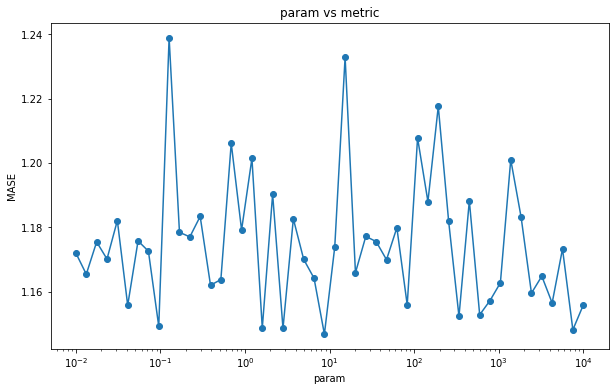

In [85]:
check_hyperparams(pac_train, pac_test, param = 'seasonality_prior_scale')

13:11:41 - cmdstanpy - INFO - Chain [1] start processing
13:11:41 - cmdstanpy - INFO - Chain [1] done processing
13:11:41 - cmdstanpy - INFO - Chain [1] start processing
13:11:41 - cmdstanpy - INFO - Chain [1] done processing
13:11:42 - cmdstanpy - INFO - Chain [1] start processing
13:11:42 - cmdstanpy - INFO - Chain [1] done processing
13:11:42 - cmdstanpy - INFO - Chain [1] start processing
13:11:43 - cmdstanpy - INFO - Chain [1] done processing
13:11:43 - cmdstanpy - INFO - Chain [1] start processing
13:11:43 - cmdstanpy - INFO - Chain [1] done processing
13:11:44 - cmdstanpy - INFO - Chain [1] start processing
13:11:44 - cmdstanpy - INFO - Chain [1] done processing
13:11:44 - cmdstanpy - INFO - Chain [1] start processing
13:11:45 - cmdstanpy - INFO - Chain [1] done processing
13:11:45 - cmdstanpy - INFO - Chain [1] start processing
13:11:46 - cmdstanpy - INFO - Chain [1] done processing
13:11:46 - cmdstanpy - INFO - Chain [1] start processing
13:11:46 - cmdstanpy - INFO - Chain [1]

Lowest 5 MASEs and params:
param: 12.708129525529298, MASE: 1.15702156450457
param: 13.76497763833569, MASE: 1.1571267458183006
param: 18.947460938388147, MASE: 1.1571918797104794
param: 35.90062760117446, MASE: 1.1589454462991662
param: 22.229964825261955, MASE: 1.161350840354556


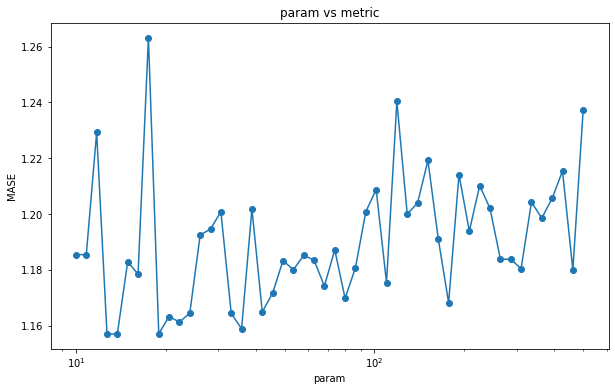

In [86]:
check_hyperparams(pac_train, pac_test, param = 'n_changepoints')

13:13:07 - cmdstanpy - INFO - Chain [1] start processing
13:13:08 - cmdstanpy - INFO - Chain [1] done processing
13:13:08 - cmdstanpy - INFO - Chain [1] start processing
13:13:08 - cmdstanpy - INFO - Chain [1] done processing
13:13:09 - cmdstanpy - INFO - Chain [1] start processing
13:13:09 - cmdstanpy - INFO - Chain [1] done processing
13:13:09 - cmdstanpy - INFO - Chain [1] start processing
13:13:09 - cmdstanpy - INFO - Chain [1] done processing
13:13:10 - cmdstanpy - INFO - Chain [1] start processing
13:13:10 - cmdstanpy - INFO - Chain [1] done processing
13:13:10 - cmdstanpy - INFO - Chain [1] start processing
13:13:11 - cmdstanpy - INFO - Chain [1] done processing
13:13:11 - cmdstanpy - INFO - Chain [1] start processing
13:13:11 - cmdstanpy - INFO - Chain [1] done processing
13:13:12 - cmdstanpy - INFO - Chain [1] start processing
13:13:12 - cmdstanpy - INFO - Chain [1] done processing
13:13:12 - cmdstanpy - INFO - Chain [1] start processing
13:13:12 - cmdstanpy - INFO - Chain [1]

changepoint_prior_scale:  0.061
seasonality_prior_scale:  0.095
n_changepoints:  22


/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects inste

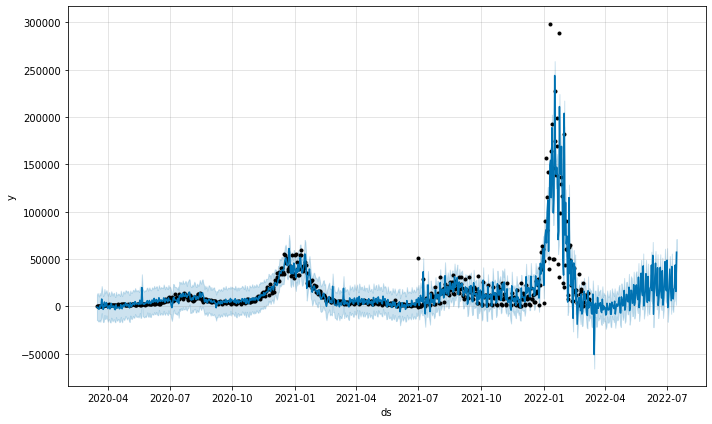

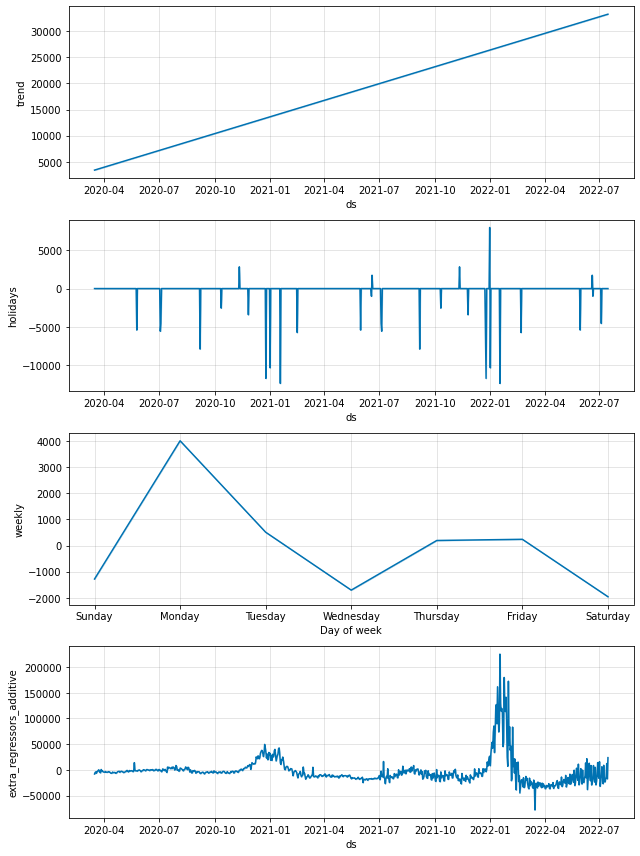

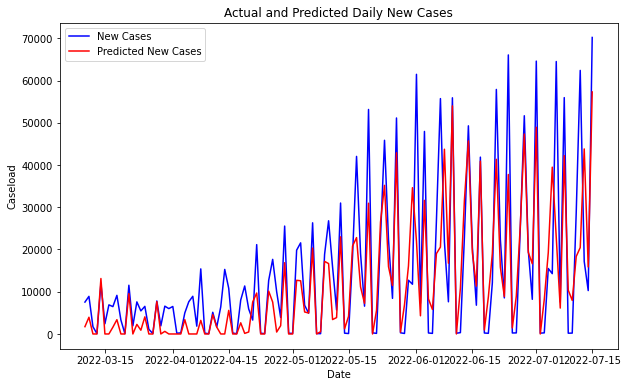

MAE: 6938.111726984493
RMSE: 10864.341304594604
MSE: 118033911.98272036
MASE: 0.9546733566425578


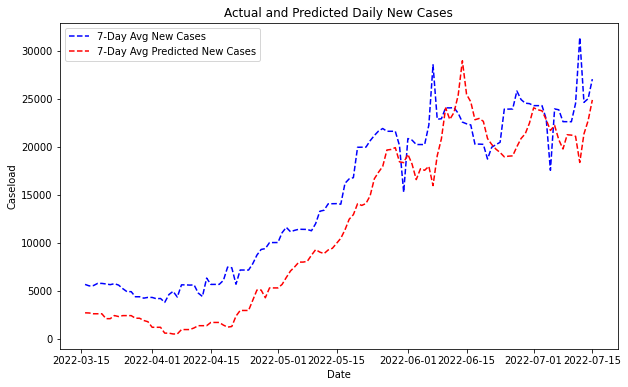

7-Day Avg MAE: 3515.225424701598
7-Day Avg RMSE: 3976.9212694672283
7-Day Avg MSE: 15815902.783540832
7-Day Avg MASE: 4.011473328862853
7-Day Avg MAPE: 0.357435668571498


In [88]:
model_pac, models_pac, forecast_pac, fig1, fig2 = search_prophet(pac_train, pac_test, changepoints=[.061, .089, .051, 0.042, .016], seasonalities=[8.7, 7500, 2.8, 1.6, .095], n_changepoints_vals=[13, 14, 19, 36, 22])

13:12:15 - cmdstanpy - INFO - Chain [1] start processing
13:12:15 - cmdstanpy - INFO - Chain [1] done processing
13:12:15 - cmdstanpy - INFO - Chain [1] start processing
13:12:15 - cmdstanpy - INFO - Chain [1] done processing
13:12:16 - cmdstanpy - INFO - Chain [1] start processing
13:12:16 - cmdstanpy - INFO - Chain [1] done processing
13:12:16 - cmdstanpy - INFO - Chain [1] start processing
13:12:16 - cmdstanpy - INFO - Chain [1] done processing
13:12:17 - cmdstanpy - INFO - Chain [1] start processing
13:12:17 - cmdstanpy - INFO - Chain [1] done processing
13:12:17 - cmdstanpy - INFO - Chain [1] start processing
13:12:17 - cmdstanpy - INFO - Chain [1] done processing
13:12:18 - cmdstanpy - INFO - Chain [1] start processing
13:12:18 - cmdstanpy - INFO - Chain [1] done processing
13:12:19 - cmdstanpy - INFO - Chain [1] start processing
13:12:19 - cmdstanpy - INFO - Chain [1] done processing
13:12:19 - cmdstanpy - INFO - Chain [1] start processing
13:12:19 - cmdstanpy - INFO - Chain [1]

changepoint_prior_scale:  0.1
seasonality_prior_scale:  500
n_changepoints:  50


/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects inste

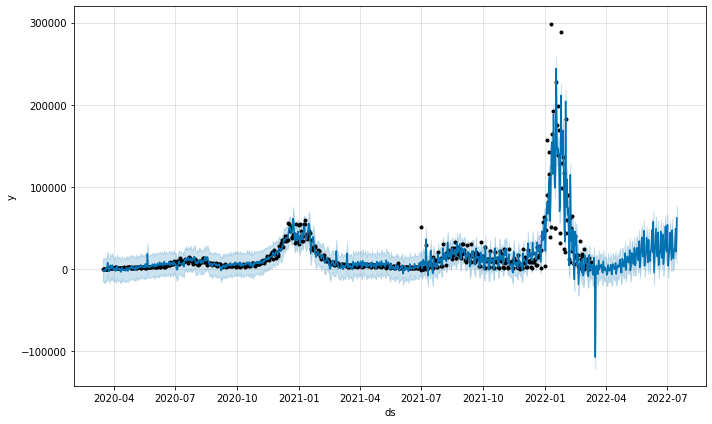

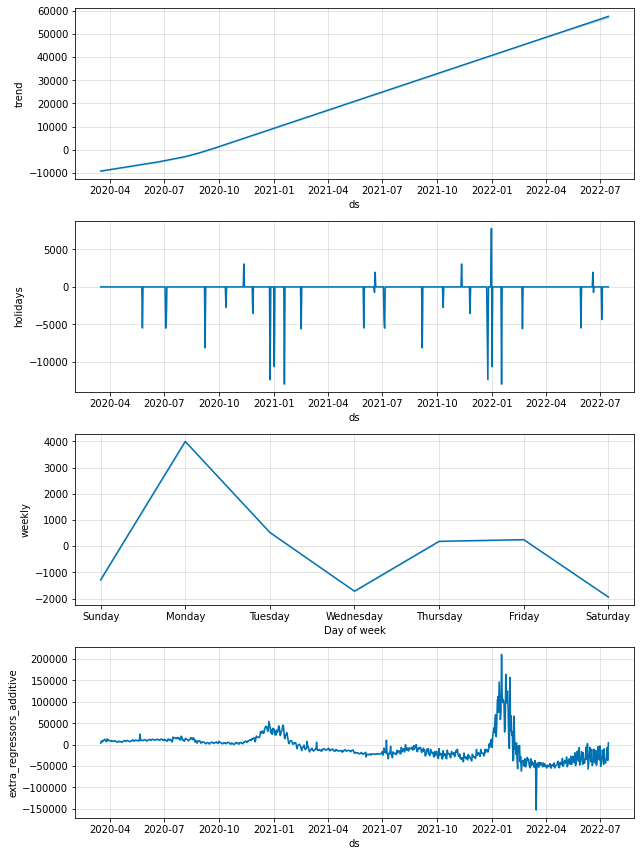

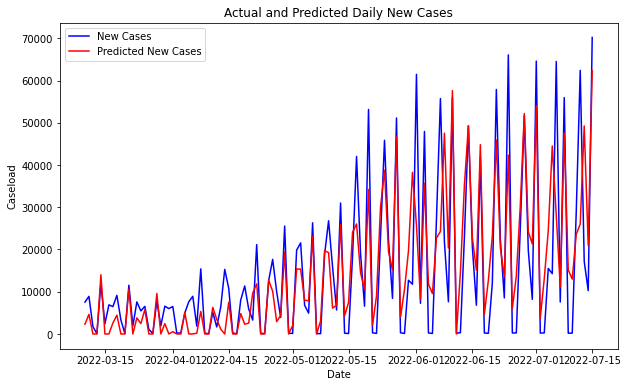

MAE: 7053.618707164844
RMSE: 10587.606616239736
MSE: 112097413.86024344
MASE: 0.9705669370320953


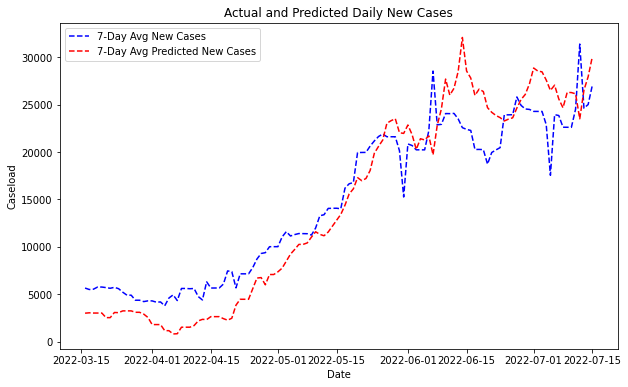

7-Day Avg MAE: 2784.6307460827784
7-Day Avg RMSE: 3320.3566943770866
7-Day Avg MSE: 11024768.577894734
7-Day Avg MASE: 3.17773986559931
7-Day Avg MAPE: 0.27239636112209253


In [87]:
model_pac, models_pac, forecast_pac, fig1, fig2 = search_prophet(pac_train, pac_test)

# South Atlantic

13:17:54 - cmdstanpy - INFO - Chain [1] start processing
13:17:54 - cmdstanpy - INFO - Chain [1] done processing
13:17:54 - cmdstanpy - INFO - Chain [1] start processing
13:17:54 - cmdstanpy - INFO - Chain [1] done processing
13:17:55 - cmdstanpy - INFO - Chain [1] start processing
13:17:55 - cmdstanpy - INFO - Chain [1] done processing
13:17:55 - cmdstanpy - INFO - Chain [1] start processing
13:17:55 - cmdstanpy - INFO - Chain [1] done processing
13:17:56 - cmdstanpy - INFO - Chain [1] start processing
13:17:56 - cmdstanpy - INFO - Chain [1] done processing
13:17:56 - cmdstanpy - INFO - Chain [1] start processing
13:17:56 - cmdstanpy - INFO - Chain [1] done processing
13:17:57 - cmdstanpy - INFO - Chain [1] start processing
13:17:57 - cmdstanpy - INFO - Chain [1] done processing
13:17:57 - cmdstanpy - INFO - Chain [1] start processing
13:17:57 - cmdstanpy - INFO - Chain [1] done processing
13:17:58 - cmdstanpy - INFO - Chain [1] start processing
13:17:58 - cmdstanpy - INFO - Chain [1]

Lowest 5 MASEs and params:
param: 0.0009767781100894892, MASE: 0.6620629481825803
param: 0.0006707035611184306, MASE: 0.7114020378456986
param: 0.0011787686347935866, MASE: 0.7498508497069873
param: 0.001422529313485369, MASE: 0.8473954740397674
param: 0.0008094001216083124, MASE: 0.8492026246005824


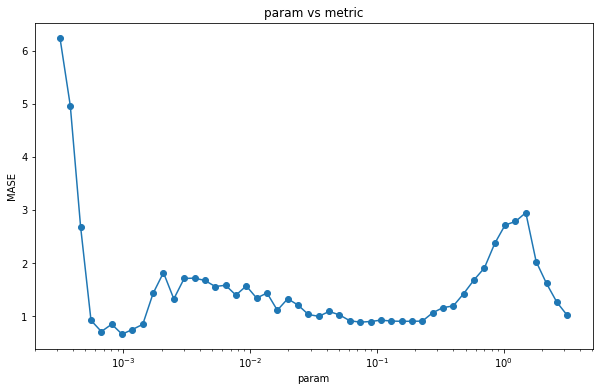

In [90]:
check_hyperparams(satl_train, satl_test)

13:18:27 - cmdstanpy - INFO - Chain [1] start processing
13:18:28 - cmdstanpy - INFO - Chain [1] done processing
13:18:28 - cmdstanpy - INFO - Chain [1] start processing
13:18:28 - cmdstanpy - INFO - Chain [1] done processing
13:18:28 - cmdstanpy - INFO - Chain [1] start processing
13:18:29 - cmdstanpy - INFO - Chain [1] done processing
13:18:29 - cmdstanpy - INFO - Chain [1] start processing
13:18:29 - cmdstanpy - INFO - Chain [1] done processing
13:18:29 - cmdstanpy - INFO - Chain [1] start processing
13:18:30 - cmdstanpy - INFO - Chain [1] done processing
13:18:30 - cmdstanpy - INFO - Chain [1] start processing
13:18:30 - cmdstanpy - INFO - Chain [1] done processing
13:18:30 - cmdstanpy - INFO - Chain [1] start processing
13:18:31 - cmdstanpy - INFO - Chain [1] done processing
13:18:31 - cmdstanpy - INFO - Chain [1] start processing
13:18:31 - cmdstanpy - INFO - Chain [1] done processing
13:18:31 - cmdstanpy - INFO - Chain [1] start processing
13:18:32 - cmdstanpy - INFO - Chain [1]

Lowest 5 MASEs and params:
param: 1842.0699693267163, MASE: 0.8916239196792358
param: 0.030888435964774818, MASE: 0.8918474982000801
param: 1389.4954943731361, MASE: 0.9164468893154873
param: 4.941713361323833, MASE: 0.9193103274942726
param: 0.040949150623804255, MASE: 0.9202101997043782


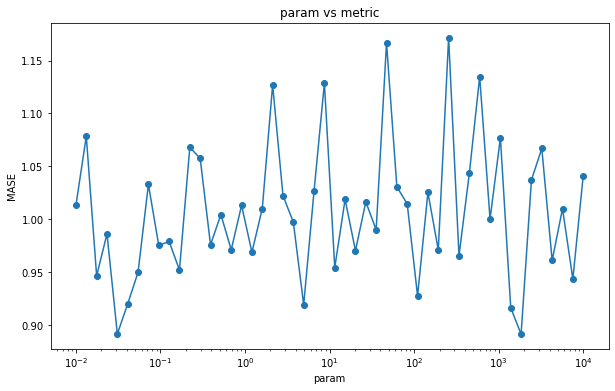

In [91]:
check_hyperparams(satl_train, satl_test, param = 'seasonality_prior_scale')

13:18:53 - cmdstanpy - INFO - Chain [1] start processing
13:18:53 - cmdstanpy - INFO - Chain [1] done processing
13:18:54 - cmdstanpy - INFO - Chain [1] start processing
13:18:54 - cmdstanpy - INFO - Chain [1] done processing
13:18:54 - cmdstanpy - INFO - Chain [1] start processing
13:18:54 - cmdstanpy - INFO - Chain [1] done processing
13:18:54 - cmdstanpy - INFO - Chain [1] start processing
13:18:55 - cmdstanpy - INFO - Chain [1] done processing
13:18:55 - cmdstanpy - INFO - Chain [1] start processing
13:18:55 - cmdstanpy - INFO - Chain [1] done processing
13:18:56 - cmdstanpy - INFO - Chain [1] start processing
13:18:56 - cmdstanpy - INFO - Chain [1] done processing
13:18:56 - cmdstanpy - INFO - Chain [1] start processing
13:18:56 - cmdstanpy - INFO - Chain [1] done processing
13:18:57 - cmdstanpy - INFO - Chain [1] start processing
13:18:57 - cmdstanpy - INFO - Chain [1] done processing
13:18:57 - cmdstanpy - INFO - Chain [1] start processing
13:18:57 - cmdstanpy - INFO - Chain [1]

Lowest 5 MASEs and params:
param: 20.523191520530943, MASE: 0.9175421391724333
param: 13.76497763833569, MASE: 0.944082666542383
param: 12.708129525529298, MASE: 0.9506155251021479
param: 10.0, MASE: 0.9581932702423265
param: 10.831631524280024, MASE: 0.9581932702423265


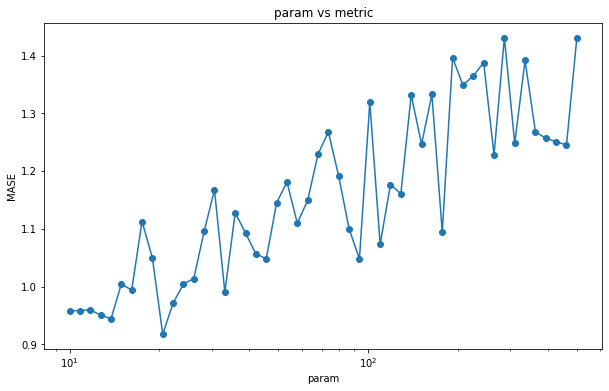

In [92]:
check_hyperparams(satl_train, satl_test, param = 'n_changepoints')

13:24:31 - cmdstanpy - INFO - Chain [1] start processing
13:24:31 - cmdstanpy - INFO - Chain [1] done processing
13:24:32 - cmdstanpy - INFO - Chain [1] start processing
13:24:32 - cmdstanpy - INFO - Chain [1] done processing
13:24:32 - cmdstanpy - INFO - Chain [1] start processing
13:24:32 - cmdstanpy - INFO - Chain [1] done processing
13:24:33 - cmdstanpy - INFO - Chain [1] start processing
13:24:33 - cmdstanpy - INFO - Chain [1] done processing
13:24:34 - cmdstanpy - INFO - Chain [1] start processing
13:24:34 - cmdstanpy - INFO - Chain [1] done processing
13:24:34 - cmdstanpy - INFO - Chain [1] start processing
13:24:34 - cmdstanpy - INFO - Chain [1] done processing
13:24:35 - cmdstanpy - INFO - Chain [1] start processing
13:24:35 - cmdstanpy - INFO - Chain [1] done processing
13:24:35 - cmdstanpy - INFO - Chain [1] start processing
13:24:35 - cmdstanpy - INFO - Chain [1] done processing
13:24:36 - cmdstanpy - INFO - Chain [1] start processing
13:24:36 - cmdstanpy - INFO - Chain [1]

changepoint_prior_scale:  0.00067
seasonality_prior_scale:  0.04
n_changepoints:  11


/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects inste

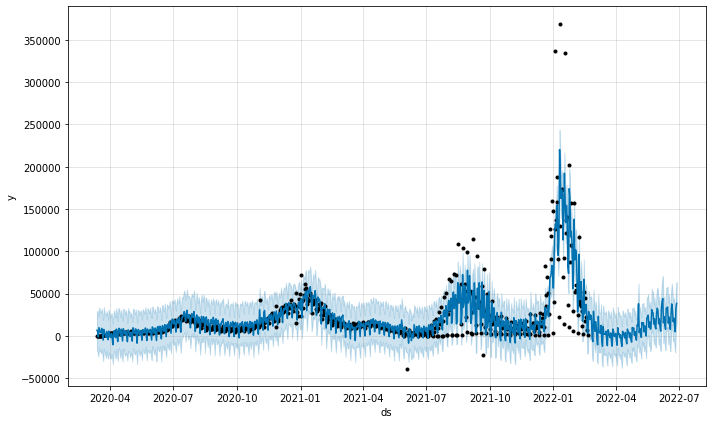

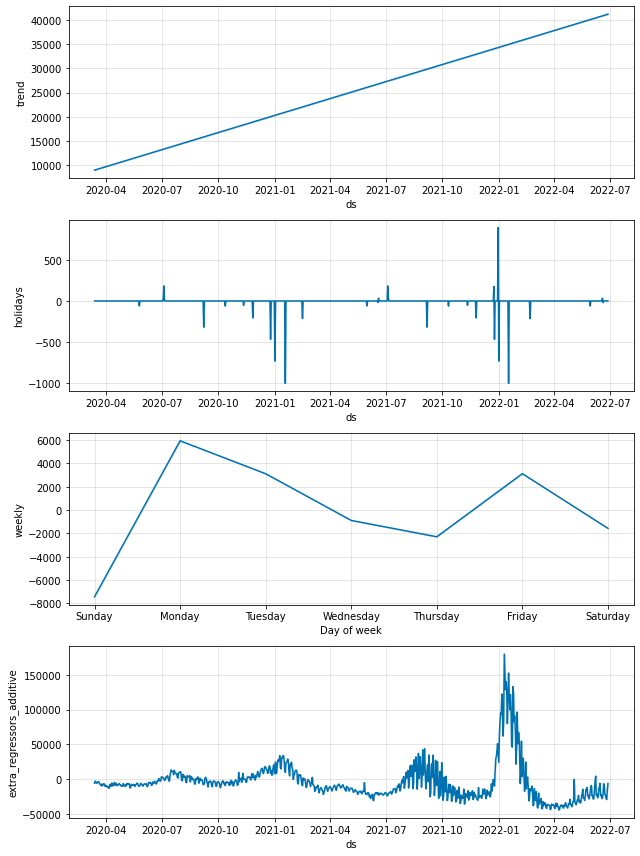

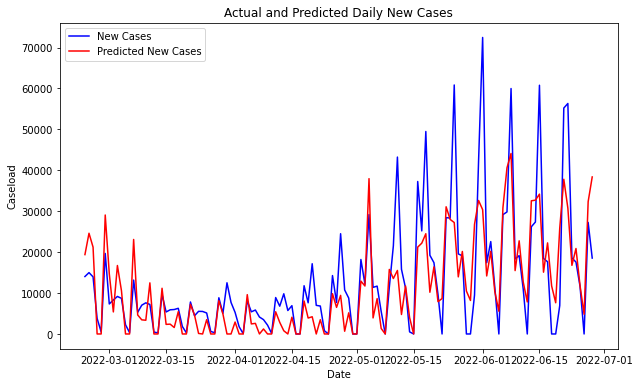

MAE: 5904.100038917434
RMSE: 9230.494958353771
MSE: 85202037.17619438
MASE: 0.5049656898919768


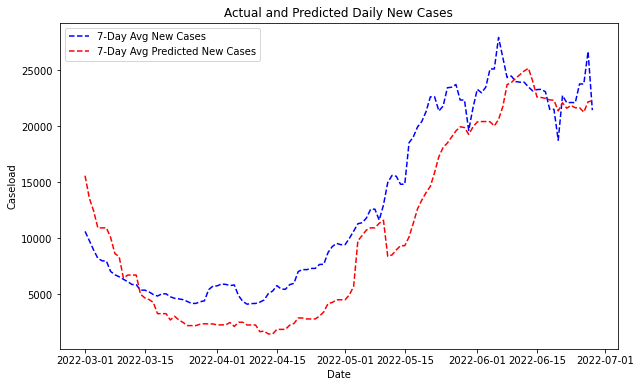

7-Day Avg MAE: 2979.979462530728
7-Day Avg RMSE: 3587.52168667348
7-Day Avg MSE: 12870311.852352532
7-Day Avg MASE: 4.796817733877131
7-Day Avg MAPE: 0.3160578939376916


In [7]:
model_satl, models_satl, forecast_satl, fig1, fig2 = search_prophet(satl_train, satl_test, changepoints=[.00098, .00067, .0012, .0014, 1.7],\
                                                                    seasonalities=[1800, .031, 1400, 4.9, .04], n_changepoints_vals=[21, 14, 13, 10, 11])

13:17:26 - cmdstanpy - INFO - Chain [1] start processing
13:17:26 - cmdstanpy - INFO - Chain [1] done processing
13:17:26 - cmdstanpy - INFO - Chain [1] start processing
13:17:26 - cmdstanpy - INFO - Chain [1] done processing
13:17:27 - cmdstanpy - INFO - Chain [1] start processing
13:17:27 - cmdstanpy - INFO - Chain [1] done processing
13:17:27 - cmdstanpy - INFO - Chain [1] start processing
13:17:27 - cmdstanpy - INFO - Chain [1] done processing
13:17:28 - cmdstanpy - INFO - Chain [1] start processing
13:17:28 - cmdstanpy - INFO - Chain [1] done processing
13:17:28 - cmdstanpy - INFO - Chain [1] start processing
13:17:28 - cmdstanpy - INFO - Chain [1] done processing
13:17:29 - cmdstanpy - INFO - Chain [1] start processing
13:17:29 - cmdstanpy - INFO - Chain [1] done processing
13:17:29 - cmdstanpy - INFO - Chain [1] start processing
13:17:29 - cmdstanpy - INFO - Chain [1] done processing
13:17:30 - cmdstanpy - INFO - Chain [1] start processing
13:17:30 - cmdstanpy - INFO - Chain [1]

changepoint_prior_scale:  0.1
seasonality_prior_scale:  500
n_changepoints:  50


/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects inste

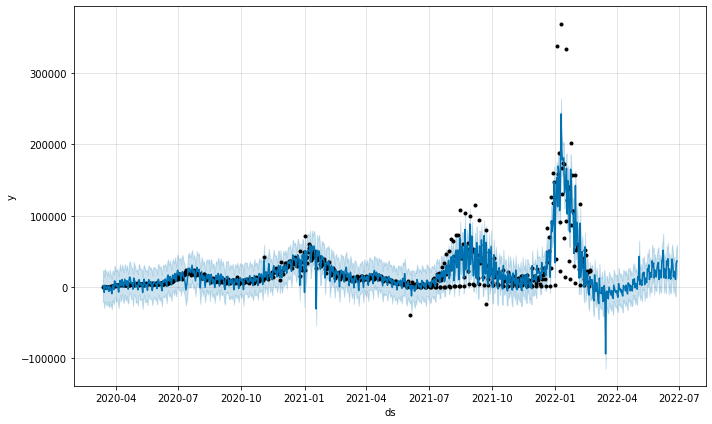

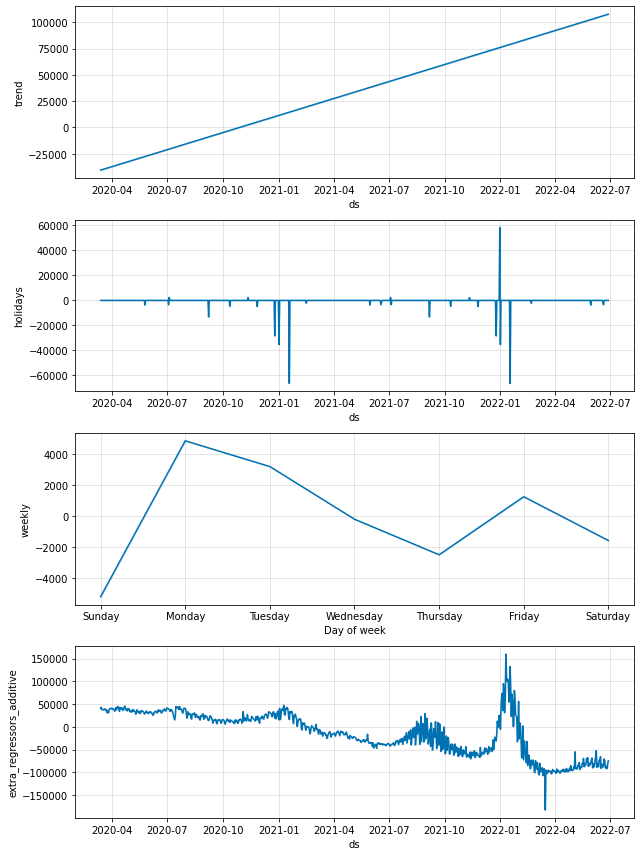

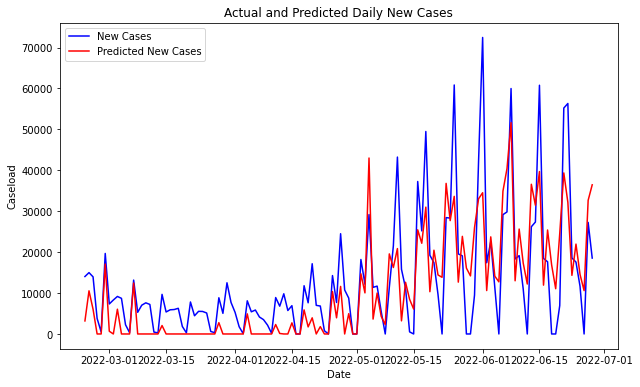

MAE: 6991.620441587099
RMSE: 9246.466656796492
MSE: 85497145.63524932
MASE: 0.5979791020607822


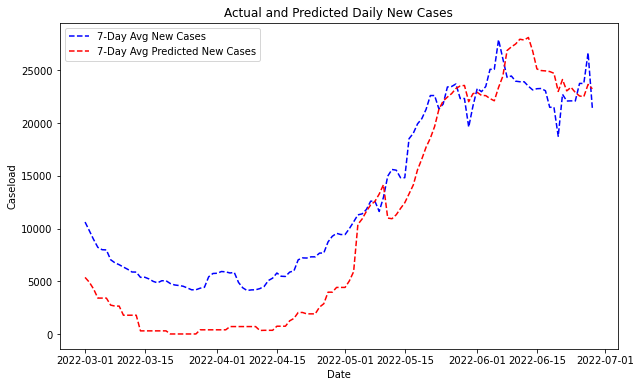

7-Day Avg MAE: 3536.1167414129113
7-Day Avg RMSE: 3890.3391995964575
7-Day Avg MSE: 15134739.087916806
7-Day Avg MASE: 5.692021608720856
7-Day Avg MAPE: 0.4716457044291098


In [89]:
model_satl, models_satl, forecast_satl, fig1, fig2 = search_prophet(satl_train, satl_test)

# West North Central

13:29:28 - cmdstanpy - INFO - Chain [1] start processing
13:29:28 - cmdstanpy - INFO - Chain [1] done processing
13:29:29 - cmdstanpy - INFO - Chain [1] start processing
13:29:29 - cmdstanpy - INFO - Chain [1] done processing
13:29:29 - cmdstanpy - INFO - Chain [1] start processing
13:29:29 - cmdstanpy - INFO - Chain [1] done processing
13:29:29 - cmdstanpy - INFO - Chain [1] start processing
13:29:29 - cmdstanpy - INFO - Chain [1] done processing
13:29:30 - cmdstanpy - INFO - Chain [1] start processing
13:29:30 - cmdstanpy - INFO - Chain [1] done processing
13:29:30 - cmdstanpy - INFO - Chain [1] start processing
13:29:30 - cmdstanpy - INFO - Chain [1] done processing
13:29:31 - cmdstanpy - INFO - Chain [1] start processing
13:29:31 - cmdstanpy - INFO - Chain [1] done processing
13:29:31 - cmdstanpy - INFO - Chain [1] start processing
13:29:31 - cmdstanpy - INFO - Chain [1] done processing
13:29:31 - cmdstanpy - INFO - Chain [1] start processing
13:29:32 - cmdstanpy - INFO - Chain [1]

Lowest 5 MASEs and params:
param: 0.0006707035611184306, MASE: 0.524331810228661
param: 0.0009767781100894892, MASE: 0.5265297321879355
param: 0.0008094001216083124, MASE: 0.5480851229821144
param: 0.001422529313485369, MASE: 0.5757707627457472
param: 0.0011787686347935866, MASE: 0.6637783625379989


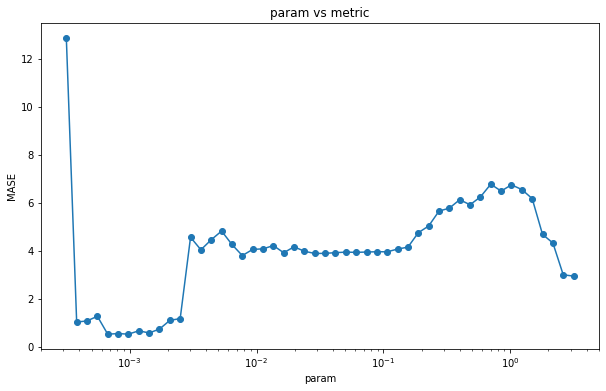

In [8]:
check_hyperparams(wnc_train, wnc_test)

13:29:58 - cmdstanpy - INFO - Chain [1] start processing
13:29:58 - cmdstanpy - INFO - Chain [1] done processing
13:29:58 - cmdstanpy - INFO - Chain [1] start processing
13:29:59 - cmdstanpy - INFO - Chain [1] done processing
13:29:59 - cmdstanpy - INFO - Chain [1] start processing
13:29:59 - cmdstanpy - INFO - Chain [1] done processing
13:29:59 - cmdstanpy - INFO - Chain [1] start processing
13:29:59 - cmdstanpy - INFO - Chain [1] done processing
13:30:00 - cmdstanpy - INFO - Chain [1] start processing
13:30:00 - cmdstanpy - INFO - Chain [1] done processing
13:30:00 - cmdstanpy - INFO - Chain [1] start processing
13:30:00 - cmdstanpy - INFO - Chain [1] done processing
13:30:01 - cmdstanpy - INFO - Chain [1] start processing
13:30:01 - cmdstanpy - INFO - Chain [1] done processing
13:30:01 - cmdstanpy - INFO - Chain [1] start processing
13:30:01 - cmdstanpy - INFO - Chain [1] done processing
13:30:02 - cmdstanpy - INFO - Chain [1] start processing
13:30:02 - cmdstanpy - INFO - Chain [1]

Lowest 5 MASEs and params:
param: 193.06977288832496, MASE: 3.858031813765996
param: 0.517947467923121, MASE: 3.8682258308991115
param: 0.9102981779915218, MASE: 3.872821073622897
param: 596.3623316594636, MASE: 3.88890554746604
param: 2.1209508879201904, MASE: 3.902708463730328


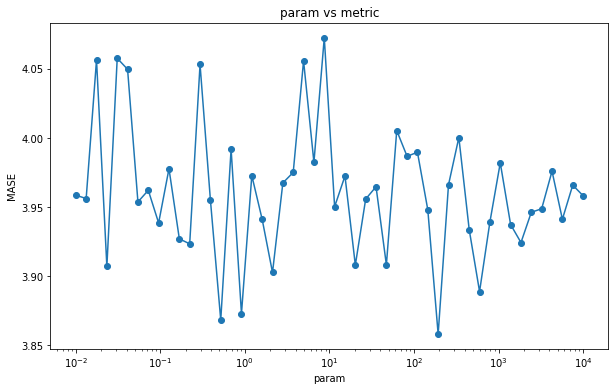

In [9]:
check_hyperparams(wnc_train, wnc_test, param = 'seasonality_prior_scale')

13:30:21 - cmdstanpy - INFO - Chain [1] start processing
13:30:21 - cmdstanpy - INFO - Chain [1] done processing
13:30:22 - cmdstanpy - INFO - Chain [1] start processing
13:30:22 - cmdstanpy - INFO - Chain [1] done processing
13:30:22 - cmdstanpy - INFO - Chain [1] start processing
13:30:22 - cmdstanpy - INFO - Chain [1] done processing
13:30:22 - cmdstanpy - INFO - Chain [1] start processing
13:30:23 - cmdstanpy - INFO - Chain [1] done processing
13:30:23 - cmdstanpy - INFO - Chain [1] start processing
13:30:23 - cmdstanpy - INFO - Chain [1] done processing
13:30:23 - cmdstanpy - INFO - Chain [1] start processing
13:30:23 - cmdstanpy - INFO - Chain [1] done processing
13:30:24 - cmdstanpy - INFO - Chain [1] start processing
13:30:24 - cmdstanpy - INFO - Chain [1] done processing
13:30:24 - cmdstanpy - INFO - Chain [1] start processing
13:30:24 - cmdstanpy - INFO - Chain [1] done processing
13:30:25 - cmdstanpy - INFO - Chain [1] start processing
13:30:25 - cmdstanpy - INFO - Chain [1]

Lowest 5 MASEs and params:
param: 364.1031949310677, MASE: 3.806383430952741
param: 177.41061109663522, MASE: 3.8093029599584356
param: 151.213942542505, MASE: 3.8163970034323973
param: 462.7070561843051, MASE: 3.820941050670083
param: 286.5120269663782, MASE: 3.84051615001226


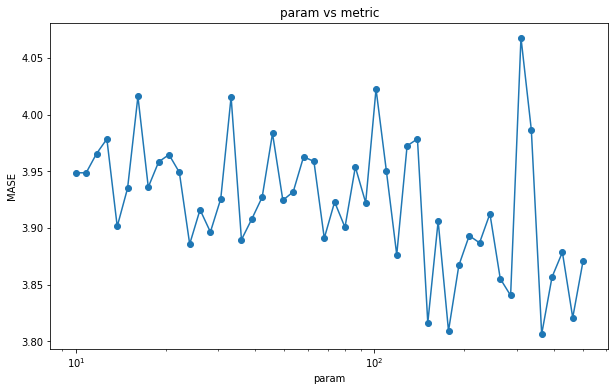

In [10]:
check_hyperparams(wnc_train, wnc_test, param = 'n_changepoints')

23:37:47 - cmdstanpy - INFO - Chain [1] start processing
23:37:47 - cmdstanpy - INFO - Chain [1] done processing
23:37:48 - cmdstanpy - INFO - Chain [1] start processing
23:37:48 - cmdstanpy - INFO - Chain [1] done processing
23:37:48 - cmdstanpy - INFO - Chain [1] start processing
23:37:48 - cmdstanpy - INFO - Chain [1] done processing
23:37:48 - cmdstanpy - INFO - Chain [1] start processing
23:37:48 - cmdstanpy - INFO - Chain [1] done processing
23:37:49 - cmdstanpy - INFO - Chain [1] start processing
23:37:49 - cmdstanpy - INFO - Chain [1] done processing
23:37:49 - cmdstanpy - INFO - Chain [1] start processing
23:37:49 - cmdstanpy - INFO - Chain [1] done processing
23:37:49 - cmdstanpy - INFO - Chain [1] start processing
23:37:50 - cmdstanpy - INFO - Chain [1] done processing
23:37:50 - cmdstanpy - INFO - Chain [1] start processing
23:37:50 - cmdstanpy - INFO - Chain [1] done processing
23:37:50 - cmdstanpy - INFO - Chain [1] start processing
23:37:50 - cmdstanpy - INFO - Chain [1]

changepoint_prior_scale:  0.00067
seasonality_prior_scale:  2.1
n_changepoints:  287


/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects inste

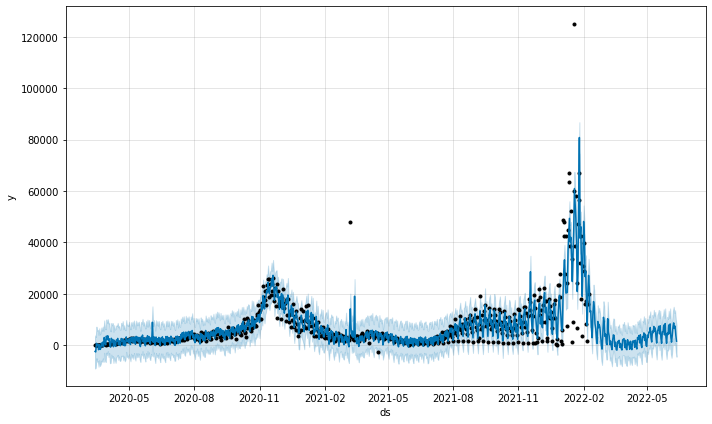

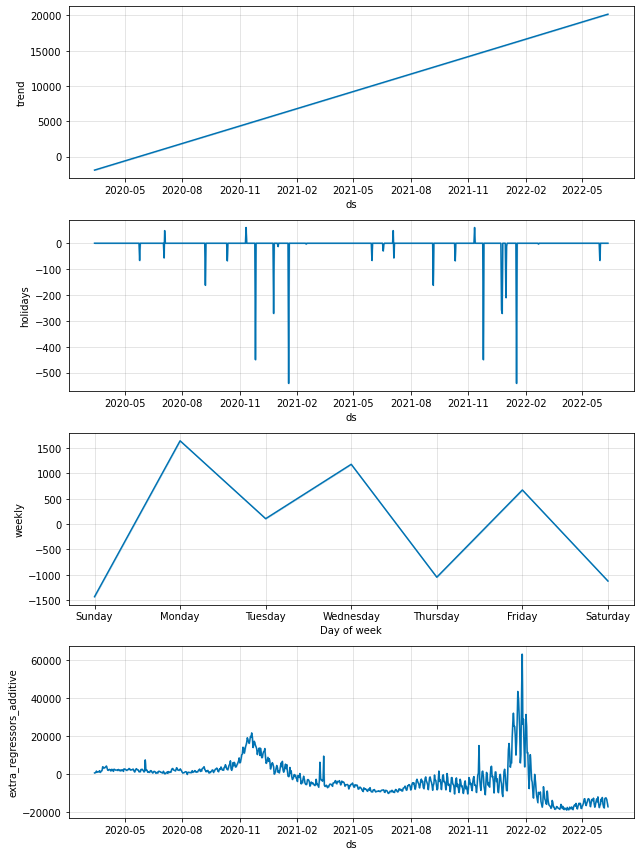

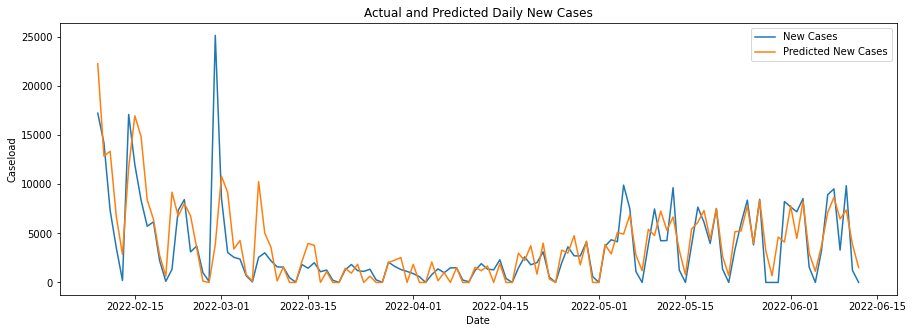

MAE: 1604.7526366176992
RMSE: 2895.2693483845887
MSE: 8382584.599695322
MASE: 0.46287795221392386


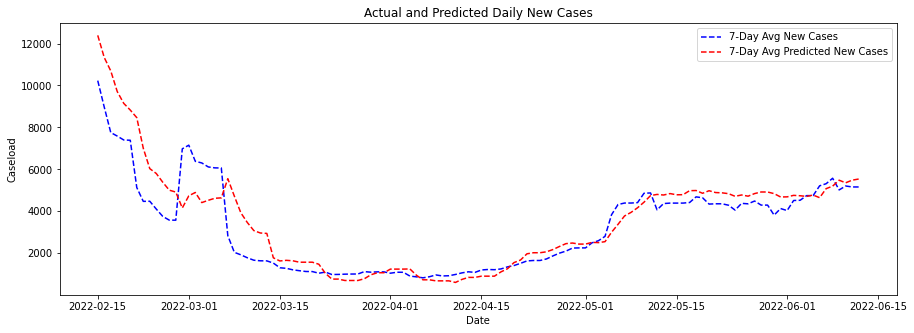

7-Day Avg MAE: 692.3606267253494
7-Day Avg RMSE: 1013.655510253238
7-Day Avg MSE: 1027497.4934667523
7-Day Avg MASE: 3.0867887163069443
7-Day Avg MAPE: 0.23837808127664833


In [21]:
model_wnc, models_wnc, forecast_wnc, fig1, fig2 = search_prophet(wnc_train, wnc_test, changepoints=[.00067, .00098, .0008, .0014, .0012],\
                                                                     seasonalities=[190, .52, .91, 600, 2.1], n_changepoints_vals=[364, 177, 151, 463, 287])

13:30:48 - cmdstanpy - INFO - Chain [1] start processing
13:30:48 - cmdstanpy - INFO - Chain [1] done processing
13:30:48 - cmdstanpy - INFO - Chain [1] start processing
13:30:48 - cmdstanpy - INFO - Chain [1] done processing
13:30:48 - cmdstanpy - INFO - Chain [1] start processing
13:30:48 - cmdstanpy - INFO - Chain [1] done processing
13:30:49 - cmdstanpy - INFO - Chain [1] start processing
13:30:49 - cmdstanpy - INFO - Chain [1] done processing
13:30:49 - cmdstanpy - INFO - Chain [1] start processing
13:30:49 - cmdstanpy - INFO - Chain [1] done processing
13:30:49 - cmdstanpy - INFO - Chain [1] start processing
13:30:49 - cmdstanpy - INFO - Chain [1] done processing
13:30:50 - cmdstanpy - INFO - Chain [1] start processing
13:30:50 - cmdstanpy - INFO - Chain [1] done processing
13:30:50 - cmdstanpy - INFO - Chain [1] start processing
13:30:50 - cmdstanpy - INFO - Chain [1] done processing
13:30:50 - cmdstanpy - INFO - Chain [1] start processing
13:30:51 - cmdstanpy - INFO - Chain [1]

changepoint_prior_scale:  0.001
seasonality_prior_scale:  500
n_changepoints:  50


/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects inste

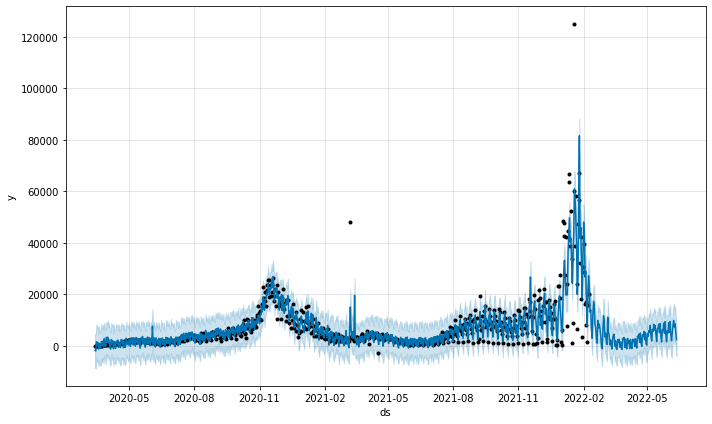

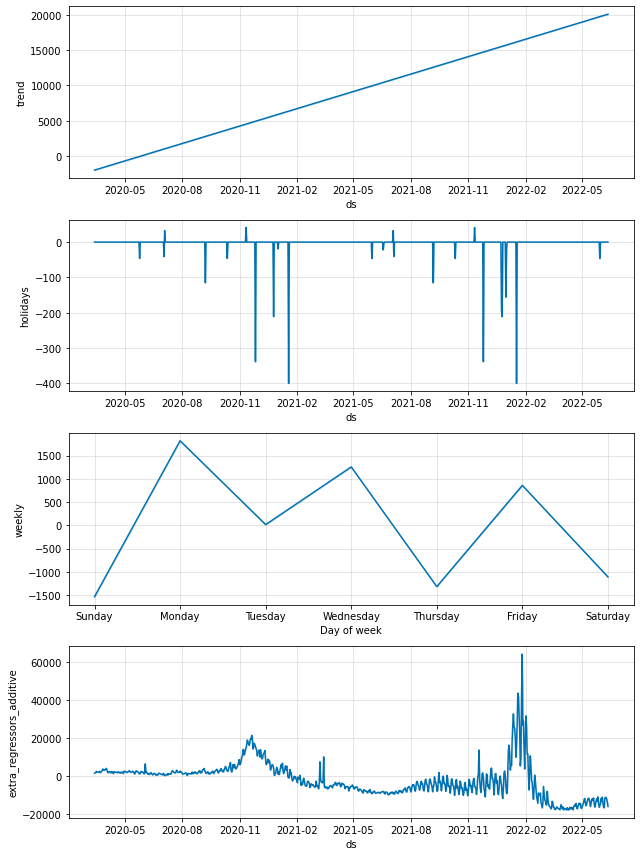

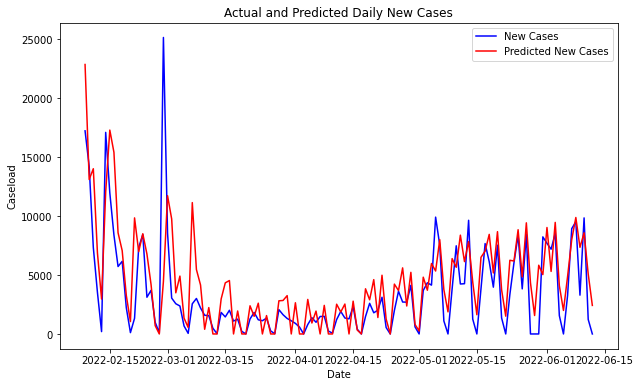

MAE: 1929.0159971069736
RMSE: 3105.1404765584757
MSE: 9641897.379161797
MASE: 0.5564091026581638


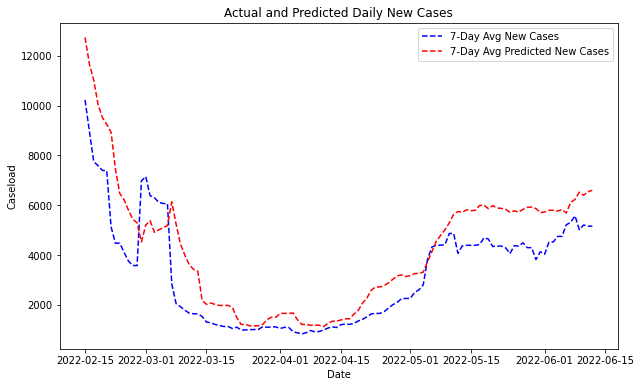

7-Day Avg MAE: 1118.1842268326202
7-Day Avg RMSE: 1366.6718345802587
7-Day Avg MSE: 1867791.90343497
7-Day Avg MASE: 4.985261034360553
7-Day Avg MAPE: 0.4031956742764733


In [11]:
model_wnc, models_wnc, forecast_wnc, fig1, fig2 = search_prophet(wnc_train, wnc_test)

# West South Central

13:31:07 - cmdstanpy - INFO - Chain [1] start processing
13:31:07 - cmdstanpy - INFO - Chain [1] done processing
13:31:07 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
13:31:07 - cmdstanpy - INFO - Chain [1] start processing
13:31:08 - cmdstanpy - INFO - Chain [1] done processing
13:31:09 - cmdstanpy - INFO - Chain [1] start processing
13:31:09 - cmdstanpy - INFO - Chain [1] done processing
13:31:09 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
13:31:09 - cmdstanpy - INFO - Chain [1] start processing
13:31:10 - cmdstanpy - INFO - Chain [1] done processing
13:31:11 - cmdstanpy - INFO - Chain [1] start processing
13:31:11 - cmdstanpy - INFO - Chain [1] done processing
13:31:11 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abn

Lowest 5 MASEs and params:
param: 0.0006707035611184306, MASE: 0.8752222141099758
param: 0.12949258422052617, MASE: 1.1288512934319679
param: 0.15627069765469948, MASE: 1.1371638895847793
param: 0.0008094001216083124, MASE: 1.1655682743907214
param: 0.18858632787726495, MASE: 1.175173122990095


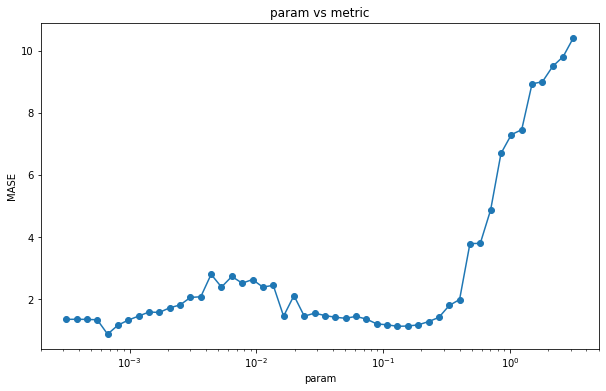

In [12]:
check_hyperparams(wsc_train, wsc_test)

13:31:39 - cmdstanpy - INFO - Chain [1] start processing
13:31:39 - cmdstanpy - INFO - Chain [1] done processing
13:31:39 - cmdstanpy - INFO - Chain [1] start processing
13:31:39 - cmdstanpy - INFO - Chain [1] done processing
13:31:39 - cmdstanpy - INFO - Chain [1] start processing
13:31:40 - cmdstanpy - INFO - Chain [1] done processing
13:31:40 - cmdstanpy - INFO - Chain [1] start processing
13:31:40 - cmdstanpy - INFO - Chain [1] done processing
13:31:40 - cmdstanpy - INFO - Chain [1] start processing
13:31:40 - cmdstanpy - INFO - Chain [1] done processing
13:31:41 - cmdstanpy - INFO - Chain [1] start processing
13:31:41 - cmdstanpy - INFO - Chain [1] done processing
13:31:41 - cmdstanpy - INFO - Chain [1] start processing
13:31:41 - cmdstanpy - INFO - Chain [1] done processing
13:31:41 - cmdstanpy - INFO - Chain [1] start processing
13:31:42 - cmdstanpy - INFO - Chain [1] done processing
13:31:42 - cmdstanpy - INFO - Chain [1] start processing
13:31:42 - cmdstanpy - INFO - Chain [1]

Lowest 5 MASEs and params:
param: 0.030888435964774818, MASE: 1.2655158110894253
param: 4291.934260128778, MASE: 1.277724257114907
param: 4.941713361323833, MASE: 1.2822573850822343
param: 8.68511373751352, MASE: 1.2946056066186742
param: 0.07196856730011521, MASE: 1.2991781982446675


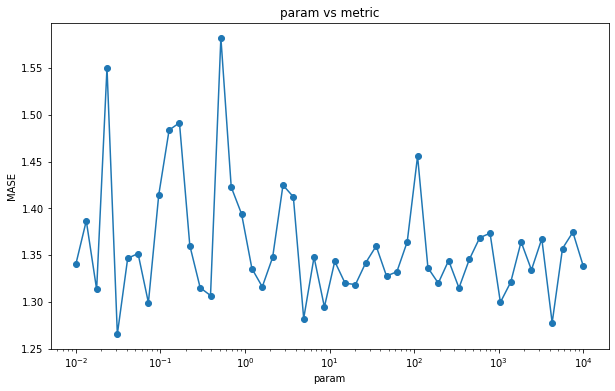

In [13]:
check_hyperparams(wsc_train, wsc_test, param = 'seasonality_prior_scale')

13:31:58 - cmdstanpy - INFO - Chain [1] start processing
13:31:58 - cmdstanpy - INFO - Chain [1] done processing
13:31:58 - cmdstanpy - INFO - Chain [1] start processing
13:31:58 - cmdstanpy - INFO - Chain [1] done processing
13:31:58 - cmdstanpy - INFO - Chain [1] start processing
13:31:58 - cmdstanpy - INFO - Chain [1] done processing
13:31:59 - cmdstanpy - INFO - Chain [1] start processing
13:31:59 - cmdstanpy - INFO - Chain [1] done processing
13:31:59 - cmdstanpy - INFO - Chain [1] start processing
13:31:59 - cmdstanpy - INFO - Chain [1] done processing
13:31:59 - cmdstanpy - INFO - Chain [1] start processing
13:32:00 - cmdstanpy - INFO - Chain [1] done processing
13:32:00 - cmdstanpy - INFO - Chain [1] start processing
13:32:00 - cmdstanpy - INFO - Chain [1] done processing
13:32:00 - cmdstanpy - INFO - Chain [1] start processing
13:32:00 - cmdstanpy - INFO - Chain [1] done processing
13:32:01 - cmdstanpy - INFO - Chain [1] start processing
13:32:01 - cmdstanpy - INFO - Chain [1]

Lowest 5 MASEs and params:
param: 128.88550621582098, MASE: 1.2799385821904956
param: 57.978277171791404, MASE: 1.3035310375153504
param: 14.909716571840645, MASE: 1.3039697175879463
param: 13.76497763833569, MASE: 1.3051482463946098
param: 26.08113761201518, MASE: 1.307214257417527


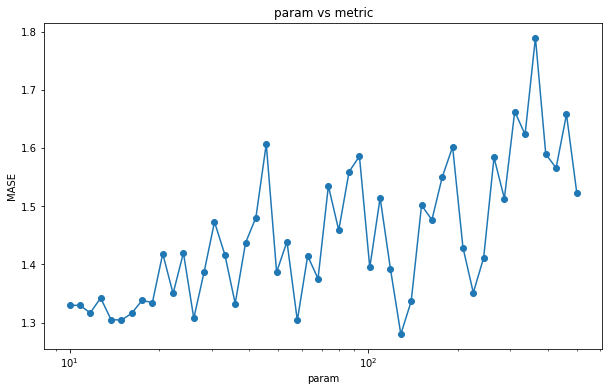

In [14]:
check_hyperparams(wsc_train, wsc_test, param = 'n_changepoints')

13:35:42 - cmdstanpy - INFO - Chain [1] start processing
13:35:42 - cmdstanpy - INFO - Chain [1] done processing
13:35:42 - cmdstanpy - INFO - Chain [1] start processing
13:35:42 - cmdstanpy - INFO - Chain [1] done processing
13:35:43 - cmdstanpy - INFO - Chain [1] start processing
13:35:43 - cmdstanpy - INFO - Chain [1] done processing
13:35:43 - cmdstanpy - INFO - Chain [1] start processing
13:35:43 - cmdstanpy - INFO - Chain [1] done processing
13:35:44 - cmdstanpy - INFO - Chain [1] start processing
13:35:44 - cmdstanpy - INFO - Chain [1] done processing
13:35:44 - cmdstanpy - INFO - Chain [1] start processing
13:35:44 - cmdstanpy - INFO - Chain [1] done processing
13:35:45 - cmdstanpy - INFO - Chain [1] start processing
13:35:45 - cmdstanpy - INFO - Chain [1] done processing
13:35:45 - cmdstanpy - INFO - Chain [1] start processing
13:35:45 - cmdstanpy - INFO - Chain [1] done processing
13:35:45 - cmdstanpy - INFO - Chain [1] start processing
13:35:46 - cmdstanpy - INFO - Chain [1]

changepoint_prior_scale:  0.00067
seasonality_prior_scale:  0.072
n_changepoints:  26


/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects inste

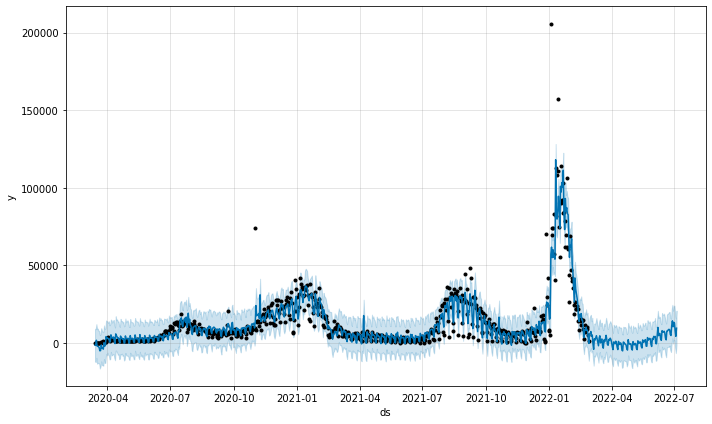

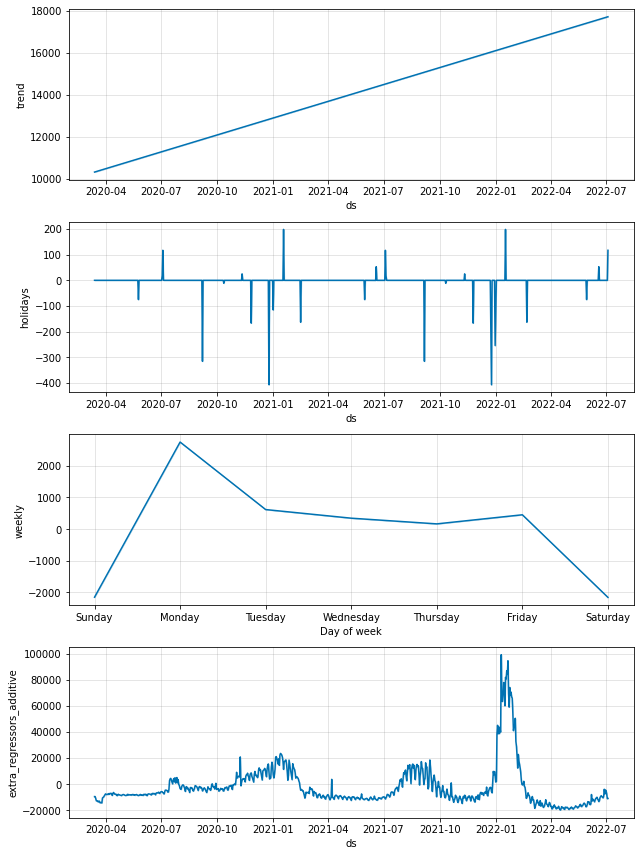

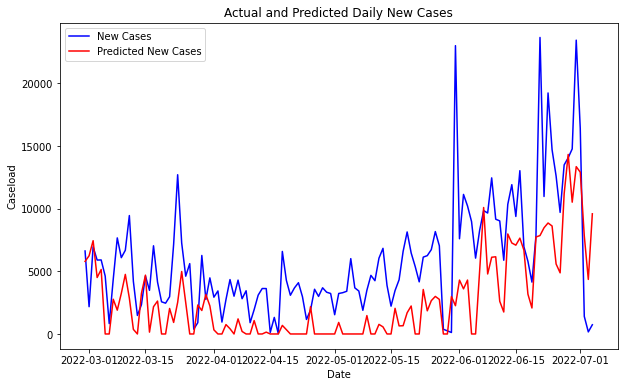

MAE: 3668.499317180566
RMSE: 4675.663701927369
MSE: 21861831.053521156
MASE: 0.7482169465304321


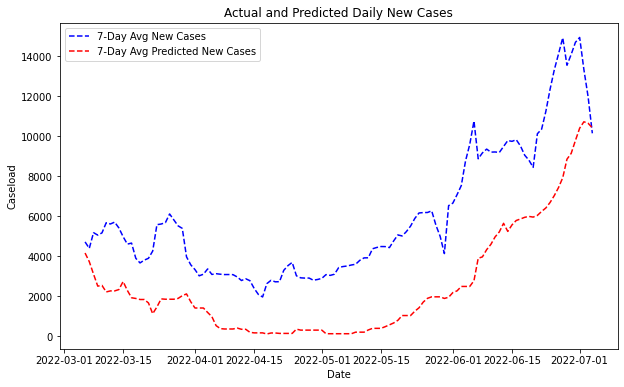

7-Day Avg MAE: 3460.1825285347886
7-Day Avg RMSE: 3692.0279604010902
7-Day Avg MSE: 13631070.460383436
7-Day Avg MASE: 9.091096187571296
7-Day Avg MAPE: 0.6737164050613834


In [17]:
model_wsc, models_wsc, forecast_wsc, fig1, fig2 = search_prophet(wsc_train, wsc_test, changepoints=[.00067, .13, .16, .00081, .19],\
                                                                     seasonalities=[.031, 4300, 4.9, 8.7, .072], n_changepoints_vals=[129, 58, 15, 14, 26])

13:32:23 - cmdstanpy - INFO - Chain [1] start processing
13:32:23 - cmdstanpy - INFO - Chain [1] done processing
13:32:23 - cmdstanpy - INFO - Chain [1] start processing
13:32:23 - cmdstanpy - INFO - Chain [1] done processing
13:32:23 - cmdstanpy - INFO - Chain [1] start processing
13:32:23 - cmdstanpy - INFO - Chain [1] done processing
13:32:24 - cmdstanpy - INFO - Chain [1] start processing
13:32:24 - cmdstanpy - INFO - Chain [1] done processing
13:32:24 - cmdstanpy - INFO - Chain [1] start processing
13:32:24 - cmdstanpy - INFO - Chain [1] done processing
13:32:24 - cmdstanpy - INFO - Chain [1] start processing
13:32:24 - cmdstanpy - INFO - Chain [1] done processing
13:32:25 - cmdstanpy - INFO - Chain [1] start processing
13:32:25 - cmdstanpy - INFO - Chain [1] done processing
13:32:25 - cmdstanpy - INFO - Chain [1] start processing
13:32:25 - cmdstanpy - INFO - Chain [1] done processing
13:32:25 - cmdstanpy - INFO - Chain [1] start processing
13:32:25 - cmdstanpy - INFO - Chain [1]

changepoint_prior_scale:  0.1
seasonality_prior_scale:  500
n_changepoints:  50


/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',
/Users/spencerhuie/opt/anaconda3/lib/python3.9/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects inste

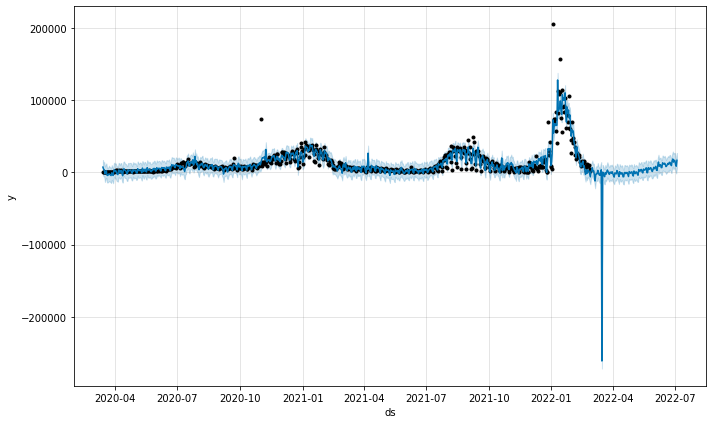

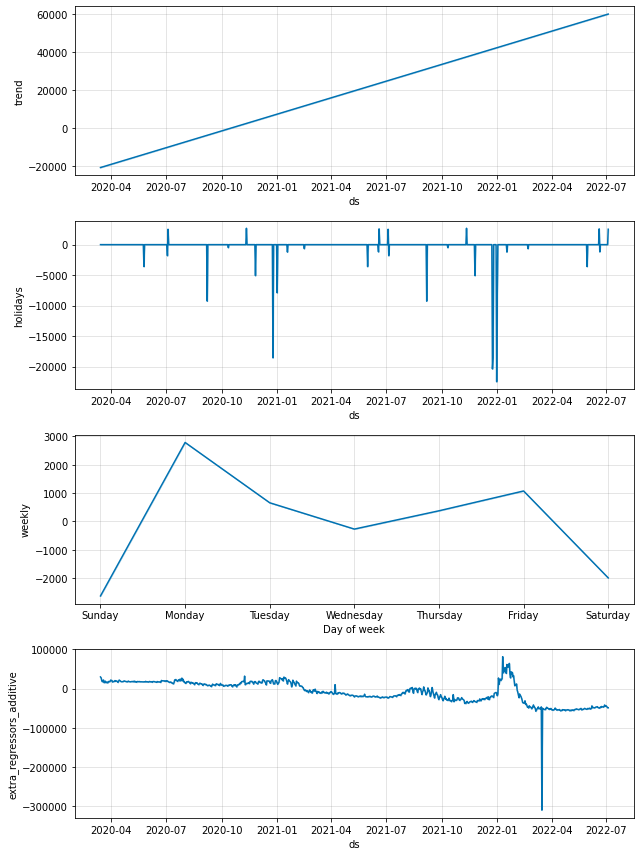

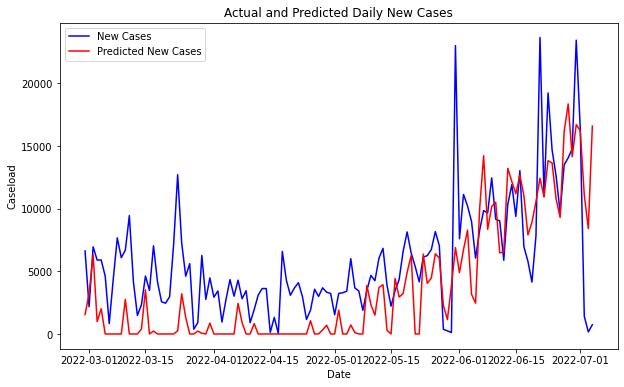

MAE: 3306.715905522052
RMSE: 4299.272296461713
MSE: 18483742.279123172
MASE: 0.6744286052572662


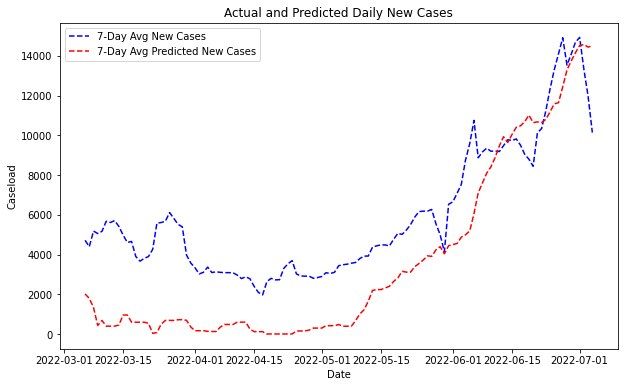

7-Day Avg MAE: 2617.4315550328006
7-Day Avg RMSE: 2924.478879408557
7-Day Avg MSE: 8552576.71610673
7-Day Avg MASE: 6.876897919389129
7-Day Avg MAPE: 0.6006769456263065


In [15]:
model_wsc, models_wsc, forecast_wsc, fig1, fig2 = search_prophet(wsc_train, wsc_test)